# Vipunen Education Market Analysis Notebook

This script replicates the analysis workflow from the Vipunen project,
displaying intermediate results and plots in a way suitable for notebooks
or interactive environments, before exporting the final results.

In [1]:
import logging
import pandas as pd
from IPython.display import display 
from pathlib import Path
import datetime
import matplotlib.pyplot as plt
import numpy as np
# import plotly.graph_objects as go
import sys 
# %matplotlib inline

In [2]:
# Add project root to path (for local environment)
project_root = str(Path().resolve().parent)
if project_root not in sys.path:
    sys.path.append(project_root)

#### Project Module Imports
Assuming the script is run from the project root or the environment includes the src path

In [3]:
try:
    from src.vipunen.config.config_loader import get_config
    from src.vipunen.data.data_loader import load_data
    from src.vipunen.data.data_processor import clean_and_prepare_data
    from src.vipunen.export.excel_exporter import export_to_excel
    from src.vipunen.analysis.market_analyzer import MarketAnalyzer
    # Import the wrapper function from analyze_cli
    from src.vipunen.cli.analyze_cli import export_analysis_results
    # Import Visualizer and constants if needed later
    from src.vipunen.visualization.education_visualizer import EducationVisualizer, COLOR_PALETTES, TEXT_CONSTANTS
    from src.vipunen.utils.data_utils import extract_data_update_date
except ImportError as e:
    print(f"Error importing project modules: {e}")
    print("Ensure the script is run from the project root or 'src' is in the Python path.")
    sys.exit(1)




### Logging Configuration

In [4]:
logging.basicConfig(
    level=logging.INFO, # Use INFO level for notebook clarity, DEBUG can be verbose
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    # Force logging to stdout for notebook-like output
    stream=sys.stdout 
)

#Silence overly verbose loggers
logging.getLogger("matplotlib").setLevel(logging.WARNING)
logging.getLogger("FileUtils").setLevel(logging.WARNING) 

logger = logging.getLogger("AnalysisNotebook")

## Analysis Configuration

### Load main project config

In [5]:
logger.info("--- Setting Analysis Configuration ---")
try:
    config = get_config() # Assumes config.yaml is discoverable
    logger.info("Successfully loaded project configuration.")
except Exception as e:
    logger.error(f"Failed to load project configuration: {e}. Exiting.")
    sys.exit(1)

2025-05-05 20:17:09,215 - AnalysisNotebook - INFO - --- Setting Analysis Configuration ---
2025-05-05 20:17:09,216 - src.vipunen.config.config_loader - INFO - Found config at project root: /Users/topi/data-science/repos/vipunen-market-analysis/config.yaml
2025-05-05 20:17:09,222 - src.vipunen.config.config_loader - INFO - Loaded configuration from /Users/topi/data-science/repos/vipunen-market-analysis/config.yaml
2025-05-05 20:17:09,222 - AnalysisNotebook - INFO - Successfully loaded project configuration.


#### Define analysis parameters

In [6]:
# institution = "AEL-Amiedu Oy"
# institution_variants = ["Taitotalo", "Ami-säätiö sr","Ammattienedistämislaitossäätiö AEL sr"]
# institution_short_name = "Taitotalo"

institution = "Rastor-instituutti ry"
institution_variants = ["Rastor Oy"]
institution_short_name = "RI"

In [7]:
ANALYSIS_PARAMS = {
    'data_file': "amm_opiskelijat_ja_tutkinnot_vuosi_tutkinto.csv", # Set to None to use path from config, or provide a specific path string
    'institution': institution, # Can be a key from config.yaml (e.g., 'default', 'ael_amiedu') OR the full institution name string.
    'short_name': None, # DEPRECATED - Use institution_short_name below. Set to None to use default from config based on institution
    'institution_short_name': institution_short_name, # Optional: Provide a short name if 'institution' is not a key in config.yaml. Defaults to the full name.
    'institution_variants': institution_variants, # Optional: Provide a list of name variants if 'institution' is not a key in config.yaml. Example: ["Amiedu", "AEL"]
    'use_dummy': False, # Set to True to use dummy data if available
    'filter_qual_types': False, # Set to True to filter for specific qualification types (e.g., Ammatti-/Erikoisammattitutkinto)
    'output_dir': None, # Set to None to use path from config, or provide specific base dir for outputs
    'include_timestamp': True # Whether to include timestamp in output filenames
    # Add other parameters as needed, mirroring analyze_cli args
}
logger.info(f"Using Analysis Parameters: {ANALYSIS_PARAMS}")

2025-05-05 20:17:09,230 - AnalysisNotebook - INFO - Using Analysis Parameters: {'data_file': 'amm_opiskelijat_ja_tutkinnot_vuosi_tutkinto.csv', 'institution': 'Rastor-instituutti ry', 'short_name': None, 'institution_short_name': 'RI', 'institution_variants': ['Rastor Oy'], 'use_dummy': False, 'filter_qual_types': False, 'output_dir': None, 'include_timestamp': True}


#### Extract key config sections (config.yaml)


In [8]:
input_cols = config.get('columns', {}).get('input', {})
output_cols = config.get('columns', {}).get('output', {})
excel_config = config.get('excel', {})
analysis_config = config.get('analysis', {})
if not input_cols:
    logger.warning("Input column mapping ('columns.input') not found or empty in config.")
# Add similar checks for output_cols, excel_config if needed

## Main Analysis Workflow

### Step 1: Prepare Data (Load, Clean, Filter)

Setup & Parameter Resolution


In [9]:
# --- Resolve Data File Path ---
data_file_param = ANALYSIS_PARAMS.get('data_file')
root_path = Path(project_root) # Define root_path object early

if data_file_param:
    data_file = Path(data_file_param)
    logger.info(f"Using data file specified in ANALYSIS_PARAMS: {data_file}")
else:
    data_file = root_path / config.get('paths', {}).get('data', 'data/raw/default.csv') # Use root_path for default data path too
    logger.info(f"Using default data file from config (relative to project root): {data_file}")

use_dummy = ANALYSIS_PARAMS.get('use_dummy', False)
filter_qual_types_flag = ANALYSIS_PARAMS.get('filter_qual_types', False)

# Ensure the data file exists (optional but good practice)
# if not data_file.exists():
#     err_msg = f"Data file not found: {data_file.resolve()}"
#     logger.error(err_msg)
#     # In a notebook, raising an error is better than sys.exit
#     raise FileNotFoundError(err_msg)

institution_param = ANALYSIS_PARAMS.get('institution', 'default') # Default to 'default' key if not specified
institution_config = config.get('institutions', {})

if institution_param in institution_config:
    logger.info(f"Using institution configuration for key: '{institution_param}'")
    inst_conf = institution_config[institution_param]
    institution_name = inst_conf.get('name', institution_param) # Default name to key if missing
    institution_short_name = ANALYSIS_PARAMS.get('institution_short_name') or inst_conf.get('short_name', institution_name) # Param overrides config, defaults to name
    institution_variants = ANALYSIS_PARAMS.get('institution_variants') or inst_conf.get('variants', []) # Param overrides config
else:
    logger.info(f"Using institution name directly from ANALYSIS_PARAMS: '{institution_param}'")
    institution_name = institution_param
    institution_short_name = ANALYSIS_PARAMS.get('institution_short_name', institution_name) # Default short name to full name if not provided
    institution_variants = ANALYSIS_PARAMS.get('institution_variants', []) # Get variants from params, default to empty list
    # Ensure institution_variants is a list
    if not isinstance(institution_variants, list):
        logger.warning(f"'institution_variants' in ANALYSIS_PARAMS was not a list. Please provide a list of strings. Ignoring the provided value.")
        institution_variants = [] # Default to empty list if not a list
    elif not institution_variants: # Check if the list is empty after ensuring it's a list
        logger.warning(f"No 'institution_variants' provided in ANALYSIS_PARAMS for '{institution_name}'. Matching might be less robust if data uses slightly different names.")

# Ensure the main name is always included in the list of names to check in the data
institution_names_to_match = list(set([institution_name] + institution_variants)) # Use set to avoid duplicates

logger.info(f"Analyzing institution: '{institution_name}' (Short: '{institution_short_name}')")
logger.info(f"Will match data against names: {institution_names_to_match}")



2025-05-05 20:17:09,241 - AnalysisNotebook - INFO - Using data file specified in ANALYSIS_PARAMS: amm_opiskelijat_ja_tutkinnot_vuosi_tutkinto.csv
2025-05-05 20:17:09,242 - AnalysisNotebook - INFO - Using institution name directly from ANALYSIS_PARAMS: 'Rastor-instituutti ry'
2025-05-05 20:17:09,242 - AnalysisNotebook - INFO - Analyzing institution: 'Rastor-instituutti ry' (Short: 'RI')
2025-05-05 20:17:09,242 - AnalysisNotebook - INFO - Will match data against names: ['Rastor-instituutti ry', 'Rastor Oy']


In [10]:
# --- Resolve Output Directory ---
output_base_dir_param = ANALYSIS_PARAMS.get('output_dir')
if output_base_dir_param:
    # If user provides a path, resolve it relative to the current working directory
    output_base_dir = Path(output_base_dir_param)
    logger.info(f"Using output directory specified in ANALYSIS_PARAMS: {output_base_dir.resolve()}")
else:
    # If using default from config, resolve it relative to the project root
    relative_output_path = config.get('paths', {}).get('output', 'data/reports') # Get relative path, default if missing
    # root_path is already defined above
    output_base_dir = root_path / relative_output_path
    logger.info(f"Using default output directory from config (relative to project root): {output_base_dir.resolve()}")

output_base_dir.mkdir(parents=True, exist_ok=True) # Ensure base directory exists
# logger.info(f"Using output base directory: {output_base_dir.resolve()}") # Logged within the if/else block now

# --- Resolve Filename Timestamp ---
include_timestamp = ANALYSIS_PARAMS.get('include_timestamp', True)
timestamp_str = f"_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}" if include_timestamp else ""

logger.info(f"Using Input Columns: {input_cols}")


2025-05-05 20:17:09,247 - AnalysisNotebook - INFO - Using default output directory from config (relative to project root): /Users/topi/data-science/repos/vipunen-market-analysis/data/reports
2025-05-05 20:17:09,247 - AnalysisNotebook - INFO - Using Input Columns: {'year': 'tilastovuosi', 'degree_type': 'tutkintotyyppi', 'qualification': 'tutkinto', 'provider': 'koulutuksenJarjestaja', 'subcontractor': 'hankintakoulutuksenJarjestaja', 'volume': 'nettoopiskelijamaaraLkm', 'update_date': 'tietojoukkoPaivitettyPvm'}


In [11]:
# --- Construct Output Filenames ---
# Use institution_short_name for brevity in filenames
filename_base = f"{institution_short_name}_analysis{timestamp_str}"
excel_filename = output_base_dir / f"{filename_base}.xlsx"
pdf_filename = output_base_dir / f"{filename_base}.pdf" # Assuming PDF is still desired
# png_dir = output_base_dir / f"{filename_base}_plots" # Keep if PNGs might be re-enabled

logger.info(f"Excel report will be saved to: {excel_filename}")
logger.info(f"PDF report will be saved to: {pdf_filename}")
# logger.info(f"Individual plots (if generated) will be saved to: {png_dir}")

# --- Other Parameters ---
use_dummy_data = ANALYSIS_PARAMS.get('use_dummy', False)
filter_qual_types = ANALYSIS_PARAMS.get('filter_qual_types', False)
qual_types_to_keep = config.get('qualification_types', []) if filter_qual_types else None

logger.info(f"Use dummy data: {use_dummy_data}")
logger.info(f"Filter qualification types: {filter_qual_types}")
if filter_qual_types:
    logger.info(f"Qualification types to keep: {qual_types_to_keep}")

logger.info("Initial setup parameters resolved.")





2025-05-05 20:17:09,252 - AnalysisNotebook - INFO - Excel report will be saved to: /Users/topi/data-science/repos/vipunen-market-analysis/data/reports/RI_analysis_20250505_201709.xlsx
2025-05-05 20:17:09,252 - AnalysisNotebook - INFO - PDF report will be saved to: /Users/topi/data-science/repos/vipunen-market-analysis/data/reports/RI_analysis_20250505_201709.pdf
2025-05-05 20:17:09,253 - AnalysisNotebook - INFO - Use dummy data: False
2025-05-05 20:17:09,253 - AnalysisNotebook - INFO - Filter qualification types: False
2025-05-05 20:17:09,253 - AnalysisNotebook - INFO - Initial setup parameters resolved.


#### 1a - Load Raw Data


In [12]:
logger.info("--- Step 1a: Loading Raw Data ---")

try:

    df_raw = load_data(file_path=data_file, use_dummy=use_dummy)
    logger.info(f"Loaded {len(df_raw)} rows of raw data.")

    # Display sample and info in notebook
    print("\n--- Raw Data Sample (First 5 Rows) ---")
    display(df_raw.head())
    print("\n--- Raw Data Info ---")
    # Use buffer to capture info output for cleaner display if needed, or print directly
    # import io
    # buffer = io.StringIO()
    # df_raw.info(buf=buffer, verbose=True, show_counts=True)
    # print(buffer.getvalue())
    df_raw.info(verbose=True, show_counts=True) # Direct print often works fine

except FileNotFoundError as e:
     logger.error(f"Data File Error: {e}")
     raise
except Exception as e:
    logger.error(f"An unexpected error occurred during raw data loading: {e}", exc_info=True)
    raise

logger.info("Raw data loaded successfully.")

2025-05-05 20:17:09,258 - AnalysisNotebook - INFO - --- Step 1a: Loading Raw Data ---
2025-05-05 20:17:09,258 - src.vipunen.utils.file_utils_config - INFO - Initializing FileUtils package
2025-05-05 20:17:09,259 - src.vipunen.utils.file_utils_config - INFO - Using project root: /Users/topi/data-science/repos/vipunen-market-analysis


2025-05-05 20:17:09,281 - FileUtils.core.file_utils - INFO - Project root: /Users/topi/data-science/repos/vipunen-market-analysis


2025-05-05 20:17:09,281 - FileUtils.core.file_utils - INFO - Project root: /Users/topi/data-science/repos/vipunen-market-analysis


2025-05-05 20:17:09,283 - FileUtils.core.file_utils - INFO - FileUtils initialized with local storage


2025-05-05 20:17:09,283 - FileUtils.core.file_utils - INFO - FileUtils initialized with local storage
2025-05-05 20:17:09,284 - src.vipunen.utils.file_utils_config - INFO - FileUtils initialized successfully
2025-05-05 20:17:09,284 - src.vipunen.data.data_loader - INFO - Attempting to load data from amm_opiskelijat_ja_tutkinnot_vuosi_tutkinto.csv
2025-05-05 20:17:09,286 - src.vipunen.data.data_loader - WARNING - Input type 'raw' not found in path 'amm_opiskelijat_ja_tutkinnot_vuosi_tutkinto.csv'. Assuming full path is filename relative to 'raw'.
2025-05-05 20:17:09,286 - src.vipunen.data.data_loader - INFO - Calling FileUtils.load_single_file('amm_opiskelijat_ja_tutkinnot_vuosi_tutkinto.csv', input_type='raw')
2025-05-05 20:17:09,371 - AnalysisNotebook - INFO - Loaded 60838 rows of raw data.



--- Raw Data Sample (First 5 Rows) ---


,tilastovuosi,suorituksenTyyppi,tutkintotyyppi,tutkinto,koulutuksenJarjestaja,hankintakoulutuksenJarjestaja,hankintakoulutusKyllaEi,koodiTutkinto,koodiKoulutuksenJarjestaja,koodiHankintakoulutuksenJarjestaja,uudetOpiskelijatLkm,opiskelijatLkm,tutkinnonSuorittaneetLkm,nettoopiskelijamaaraLkm,tietojoukkoPaivitettyPvm
0,2018,Tutkinnon osa/osia,Muu ammatillinen koulutus,Tieto puuttuu,ABB Oy,Tieto puuttuu,False,-1,0763403-0,-1,78,93,50,44.506849,2025-04-03
1,2018,Koko tutkinto,Ammattitutkinnot,Ajoneuvoalan ammattitutkinto,AEL-Amiedu Oy,Tieto puuttuu,False,354345,3008326-5,-1,3,3,0,0.964384,2025-04-03
2,2018,Koko tutkinto,Ammattitutkinnot,Asioimistulkkauksen ammattitutkinto,AEL-Amiedu Oy,Tieto puuttuu,False,384201,3008326-5,-1,6,8,1,3.509589,2025-04-03
3,2018,Koko tutkinto,Ammattitutkinnot,Auto- ja kuljetusalan työnjohdon ammattitutkinto,AEL-Amiedu Oy,Tieto puuttuu,False,354315,3008326-5,-1,14,18,0,14.706849,2025-04-03
4,2018,Koko tutkinto,Erikoisammattitutkinnot,Autoalan myyjän erikoisammattitutkinto,AEL-Amiedu Oy,Tieto puuttuu,False,437108,3008326-5,-1,1,2,0,0.027397,2025-04-03


2025-05-05 20:17:09,388 - AnalysisNotebook - INFO - Raw data loaded successfully.



--- Raw Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60838 entries, 0 to 60837
Data columns (total 15 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   tilastovuosi                        60838 non-null  int64  
 1   suorituksenTyyppi                   60838 non-null  object 
 2   tutkintotyyppi                      60838 non-null  object 
 3   tutkinto                            60838 non-null  object 
 4   koulutuksenJarjestaja               60838 non-null  object 
 5   hankintakoulutuksenJarjestaja       60838 non-null  object 
 6   hankintakoulutusKyllaEi             60838 non-null  bool   
 7   koodiTutkinto                       60838 non-null  int64  
 8   koodiKoulutuksenJarjestaja          60838 non-null  object 
 9   koodiHankintakoulutuksenJarjestaja  60838 non-null  object 
 10  uudetOpiskelijatLkm                 60838 non-null  int64  
 11  opiskelijatLkm    

#### 1b - Extract Data Update Date


In [13]:
logger.info("--- Step 1b: Extracting Data Update Date ---")

# Initialize the variable
data_update_date_str = 'N/A' # Or use the default from the function

try:
    # Ensure df_raw and config exist from previous steps
    # Using globals() or locals() is generally preferred for checking existence in notebooks
    if 'df_raw' not in globals() or df_raw is None:
        logger.warning("Raw data (df_raw) is not available. Skipping date extraction.")
        # Set to default if df_raw is missing and you want to continue
        data_update_date_str = datetime.datetime.now().strftime("%d.%m.%Y")
    elif 'config' not in globals() or config is None:
        logger.warning("Config is not available. Skipping date extraction.")
        # Set to default if config is missing and you want to continue
        data_update_date_str = datetime.datetime.now().strftime("%d.%m.%Y")
    else:
        # Call the refactored function
        data_update_date_str = extract_data_update_date(df_raw, config)

except NameError as e:
    logger.error(f"A required variable (df_raw or config) might not be defined: {e}")
    # Set to default date if needed
    data_update_date_str = datetime.datetime.now().strftime("%d.%m.%Y")
    # Decide if this error should stop execution
    # raise # Uncomment to stop execution
except Exception as e:
     logger.error(f"An unexpected error occurred calling extract_data_update_date: {e}", exc_info=True)
     # Set to default date if needed
     data_update_date_str = datetime.datetime.now().strftime("%d.%m.%Y")
     # Decide if this error should stop execution
     # raise # Uncomment to stop execution

# Print the result regardless of successful extraction or fallback
print(f"Data Update Date: {data_update_date_str}")
logger.info("Date extraction step complete.")


2025-05-05 20:17:09,393 - AnalysisNotebook - INFO - --- Step 1b: Extracting Data Update Date ---
2025-05-05 20:17:09,395 - src.vipunen.utils.data_utils - INFO - Extracted data update date: 03.04.2025 from column 'tietojoukkoPaivitettyPvm'
2025-05-05 20:17:09,396 - AnalysisNotebook - INFO - Date extraction step complete.


Data Update Date: 03.04.2025


#### 1c - Clean and Prepare Data (Initial)


In [14]:
logger.info("--- Step 1c: Cleaning and Preparing Data (Initial) ---")
df_clean_initial = None # Initialize

try:
    # Ensure df_raw is available
    if df_raw is None:
         logger.error("Raw data (df_raw) is not available. Cannot perform initial cleaning.")
         raise ValueError("df_raw is not defined or loaded.")

    logger.info("Applying initial cleaning (merging qualifications, shortening names)...")
    df_clean_initial = clean_and_prepare_data(
        df_raw,
        institution_names=institution_names_to_match, # From Cell 1
        merge_qualifications=True,
        shorten_names=True
    )
    logger.info(f"Initial cleaning complete. Shape: {df_clean_initial.shape}")

    # Display sample and info
    print("\n--- Cleaned Data Sample (Initial) ---")
    display(df_clean_initial.head())
    print("\n--- Cleaned Data Info (Initial) ---")
    df_clean_initial.info(verbose=True, show_counts=True)

except Exception as e:
    logger.error(f"An unexpected error occurred during initial data cleaning: {e}", exc_info=True)
    raise

logger.info("Initial data cleaning complete.")


2025-05-05 20:17:09,401 - AnalysisNotebook - INFO - --- Step 1c: Cleaning and Preparing Data (Initial) ---
2025-05-05 20:17:09,401 - AnalysisNotebook - INFO - Applying initial cleaning (merging qualifications, shortening names)...
2025-05-05 20:17:09,409 - src.vipunen.data.data_processor - INFO - Replaced 'Tieto puuttuu' with NaN in hankintakoulutuksenJarjestaja column
2025-05-05 20:17:09,422 - src.vipunen.data.data_processor - INFO - Merged Yrittäjän ammattitutkinto into Yrittäjyyden ammattitutkinto:
2025-05-05 20:17:09,422 - src.vipunen.data.data_processor - INFO -   - Before: 594 rows with old name, 380 rows with new name
2025-05-05 20:17:09,422 - src.vipunen.data.data_processor - INFO -   - After: 0 rows with old name, 974 rows with new name
2025-05-05 20:17:09,463 - src.vipunen.data.data_processor - INFO - Shortened qualification names (erikoisammattitutkinto → EAT, ammattitutkinto → AT)
2025-05-05 20:17:09,467 - AnalysisNotebook - INFO - Initial cleaning complete. Shape: (60838, 


--- Cleaned Data Sample (Initial) ---


,tilastovuosi,suorituksenTyyppi,tutkintotyyppi,tutkinto,koulutuksenJarjestaja,hankintakoulutuksenJarjestaja,hankintakoulutusKyllaEi,koodiTutkinto,koodiKoulutuksenJarjestaja,koodiHankintakoulutuksenJarjestaja,uudetOpiskelijatLkm,opiskelijatLkm,tutkinnonSuorittaneetLkm,nettoopiskelijamaaraLkm,tietojoukkoPaivitettyPvm
0,2018,Tutkinnon osa/osia,Muu ammatillinen koulutus,Tieto puuttuu,ABB Oy,NaN,False,-1,0763403-0,-1,78,93,50,44.506849,2025-04-03
1,2018,Koko tutkinto,Ammattitutkinnot,Ajoneuvoalan AT,AEL-Amiedu Oy,NaN,False,354345,3008326-5,-1,3,3,0,0.964384,2025-04-03
2,2018,Koko tutkinto,Ammattitutkinnot,Asioimistulkkauksen AT,AEL-Amiedu Oy,NaN,False,384201,3008326-5,-1,6,8,1,3.509589,2025-04-03
3,2018,Koko tutkinto,Ammattitutkinnot,Auto- ja kuljetusalan työnjohdon AT,AEL-Amiedu Oy,NaN,False,354315,3008326-5,-1,14,18,0,14.706849,2025-04-03
4,2018,Koko tutkinto,Erikoisammattitutkinnot,Autoalan myyjän EAT,AEL-Amiedu Oy,NaN,False,437108,3008326-5,-1,1,2,0,0.027397,2025-04-03


2025-05-05 20:17:09,480 - AnalysisNotebook - INFO - Initial data cleaning complete.



--- Cleaned Data Info (Initial) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60838 entries, 0 to 60837
Data columns (total 15 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   tilastovuosi                        60838 non-null  int64  
 1   suorituksenTyyppi                   60838 non-null  object 
 2   tutkintotyyppi                      60838 non-null  object 
 3   tutkinto                            60838 non-null  object 
 4   koulutuksenJarjestaja               60838 non-null  object 
 5   hankintakoulutuksenJarjestaja       14804 non-null  object 
 6   hankintakoulutusKyllaEi             60838 non-null  bool   
 7   koodiTutkinto                       60838 non-null  int64  
 8   koodiKoulutuksenJarjestaja          60838 non-null  object 
 9   koodiHankintakoulutuksenJarjestaja  60838 non-null  object 
 10  uudetOpiskelijatLkm                 60838 non-null  int64  
 11  opis

#### 1d - Filter by Institution's Offered Qualifications


In [15]:
logger.info("--- Step 1d: Filtering by Institution's Offered Qualifications ---")
df_prepared = None # Initialize

try:
    # Ensure df_clean_initial is available
    if df_clean_initial is None:
         logger.error("Cleaned initial data (df_clean_initial) is not available. Cannot filter.")
         raise ValueError("df_clean_initial is not defined or loaded.")

    logger.info(f"Filtering data based on qualifications offered by {institution_short_name}...")

    # Ensure required columns exist before filtering
    required_filter_cols = [input_cols['provider'], input_cols['subcontractor'], input_cols['qualification']]
    if not all(col in df_clean_initial.columns for col in required_filter_cols):
        err_msg = f"Missing one or more required columns for filtering: {required_filter_cols}. Available: {df_clean_initial.columns.tolist()}"
        logger.error(err_msg)
        raise ValueError(err_msg)

    # Find qualifications offered by the institution (provider or subcontractor)
    institution_mask = (
        (df_clean_initial[input_cols['provider']].isin(institution_names_to_match)) |
        (df_clean_initial[input_cols['subcontractor']].isin(institution_names_to_match))
    )
    inst_qualifications = df_clean_initial.loc[institution_mask, input_cols['qualification']].unique()

    if len(inst_qualifications) > 0:
        # Filter the *entire* dataset to include only rows matching these qualifications
        df_prepared = df_clean_initial[df_clean_initial[input_cols['qualification']].isin(inst_qualifications)].copy()
        logger.info(f"Filtered data to {len(inst_qualifications)} qualifications associated with {institution_short_name}. Final shape: {df_prepared.shape}")
    else:
        logger.warning(f"No specific qualifications found associated with {institution_short_name} (variants: {institution_variants}). Using data before this filtering step.")
        df_prepared = df_clean_initial.copy() # Use the data before this specific filtering step

    # Display final prepared data sample and info
    print("\n--- Prepared Data Sample (Final for Analysis) ---")
    display(df_prepared.head())
    print("\n--- Prepared Data Info (Final for Analysis) ---")
    df_prepared.info(verbose=True, show_counts=True)

except ValueError as e:
     logger.error(f"Data Error during filtering: {e}")
     raise
except Exception as e:
    logger.error(f"An unexpected error occurred during qualification filtering: {e}", exc_info=True)
    raise

logger.info("--- Step 1: Data Preparation Complete ---")

2025-05-05 20:17:09,486 - AnalysisNotebook - INFO - --- Step 1d: Filtering by Institution's Offered Qualifications ---
2025-05-05 20:17:09,486 - AnalysisNotebook - INFO - Filtering data based on qualifications offered by RI...
2025-05-05 20:17:09,494 - AnalysisNotebook - INFO - Filtered data to 37 qualifications associated with RI. Final shape: (13456, 15)



--- Prepared Data Sample (Final for Analysis) ---


,tilastovuosi,suorituksenTyyppi,tutkintotyyppi,tutkinto,koulutuksenJarjestaja,hankintakoulutuksenJarjestaja,hankintakoulutusKyllaEi,koodiTutkinto,koodiKoulutuksenJarjestaja,koodiHankintakoulutuksenJarjestaja,uudetOpiskelijatLkm,opiskelijatLkm,tutkinnonSuorittaneetLkm,nettoopiskelijamaaraLkm,tietojoukkoPaivitettyPvm
1,2018,Koko tutkinto,Ammattitutkinnot,Ajoneuvoalan AT,AEL-Amiedu Oy,NaN,False,354345,3008326-5,-1,3,3,0,0.964384,2025-04-03
5,2018,Koko tutkinto,Erikoisammattitutkinnot,Autoalan työnjohdon EAT,AEL-Amiedu Oy,NaN,False,457305,3008326-5,-1,1,5,0,4.997260,2025-04-03
15,2018,Koko tutkinto,Ammattitutkinnot,Isännöinnin AT,AEL-Amiedu Oy,NaN,False,334103,3008326-5,-1,28,28,0,13.139726,2025-04-03
16,2018,Koko tutkinto,Erikoisammattitutkinnot,Johtamisen EAT,AEL-Amiedu Oy,NaN,False,437101,3008326-5,-1,132,189,8,115.156164,2025-04-03
17,2018,Koko tutkinto,Erikoisammattitutkinnot,Johtamisen ja yritysjohtamisen EAT,AEL-Amiedu Oy,NaN,False,437141,3008326-5,-1,14,14,0,1.112329,2025-04-03


2025-05-05 20:17:09,501 - AnalysisNotebook - INFO - --- Step 1: Data Preparation Complete ---



--- Prepared Data Info (Final for Analysis) ---
<class 'pandas.core.frame.DataFrame'>
Index: 13456 entries, 1 to 60836
Data columns (total 15 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   tilastovuosi                        13456 non-null  int64  
 1   suorituksenTyyppi                   13456 non-null  object 
 2   tutkintotyyppi                      13456 non-null  object 
 3   tutkinto                            13456 non-null  object 
 4   koulutuksenJarjestaja               13456 non-null  object 
 5   hankintakoulutuksenJarjestaja       5731 non-null   object 
 6   hankintakoulutusKyllaEi             13456 non-null  bool   
 7   koodiTutkinto                       13456 non-null  int64  
 8   koodiKoulutuksenJarjestaja          13456 non-null  object 
 9   koodiHankintakoulutuksenJarjestaja  13456 non-null  object 
 10  uudetOpiskelijatLkm                 13456 non-null  int64  
 1

### Step 2: Perform Market Analysis

In [16]:
# Cell 6: Step 2a - Apply Optional Qualification Type Filtering
logger.info("--- Step 2a: Applying Optional Qualification Type Filtering ---")

df_analysis_input = None # Initialize

try:
    # Ensure data from Step 1 is available
    if 'df_prepared' not in globals() or df_prepared is None or df_prepared.empty:
        logger.warning("Prepared data (df_prepared) is missing or empty. Skipping further analysis steps.")
        # Set df_analysis_input to None or an empty DataFrame to prevent downstream errors
        df_analysis_input = pd.DataFrame() # Or None, depending on how downstream cells handle it
        # Optionally, raise an error if analysis cannot proceed:
        # raise ValueError("Prepared data is required for analysis but is missing or empty.")
    elif 'filter_qual_types_flag' not in globals():
        logger.warning("filter_qual_types_flag not defined. Assuming False.")
        filter_qual_types_flag = False # Set a default
        df_analysis_input = df_prepared.copy() # Use prepared data directly
    elif 'config' not in globals():
         logger.error("Config object not found. Cannot apply filtering.")
         raise NameError("Config object not found.")
    else:
        # Apply filtering logic
        if filter_qual_types_flag:
            # Ensure 'qualification_types' exists in config, provide default if not
            qual_types = config.get('qualification_types', ['Ammattitutkinnot', 'Erikoisammattitutkinnot'])
            logger.info(f"Applying qualification type filter for: {qual_types}")
            # Ensure 'tutkintotyyppi' column exists in df_prepared
            if 'tutkintotyyppi' not in df_prepared.columns:
                 logger.error("Column 'tutkintotyyppi' not found in df_prepared. Cannot apply filter.")
                 raise KeyError("Column 'tutkintotyyppi' missing for filtering.")
            df_analysis_input = df_prepared[df_prepared['tutkintotyyppi'].isin(qual_types)].copy()
            logger.info(f"Shape before type filter: {df_prepared.shape}, after: {df_analysis_input.shape}")
        else:
            logger.info("Skipping qualification type filtering.")
            df_analysis_input = df_prepared.copy() # Use the prepared data directly

except KeyError as e:
    logger.error(f"Configuration or Data Error during filtering: {e}")
    raise # Stop execution
except NameError as e:
     logger.error(f"Variable Error during filtering setup: {e}")
     raise # Stop execution
except Exception as e:
    logger.error(f"An unexpected error occurred during optional filtering: {e}", exc_info=True)
    raise # Stop execution

logger.info("Step 2a filtering complete.")
# Display shape or head if desired
if df_analysis_input is not None:
    print(f"Shape of data for analysis: {df_analysis_input.shape}")
else:
    print("No data available for analysis.")

2025-05-05 20:17:09,507 - AnalysisNotebook - INFO - --- Step 2a: Applying Optional Qualification Type Filtering ---
2025-05-05 20:17:09,508 - AnalysisNotebook - INFO - Skipping qualification type filtering.
2025-05-05 20:17:09,509 - AnalysisNotebook - INFO - Step 2a filtering complete.


Shape of data for analysis: (13456, 15)


In [17]:
# Config check
# print("--- Checking config before MarketAnalyzer init ---")
# print(f"Config type: {type(config)}")
# if isinstance(config, dict):
#     print(f"config['columns']['output'] keys: {config.get('columns', {}).get('output', {}).keys()}")
#     print(f"market_rank exists: {'market_rank' in config.get('columns', {}).get('output', {})}")
#     print(f"market_share_growth exists: {'market_share_growth' in config.get('columns', {}).get('output', {})}")
# else:
#     print("Config object is not a dictionary!")
# print("--- End config check ---")

# logger.info("Initializing MarketAnalyzer...")

#### Step 2b - Initialize and Run Market Analyzer


In [18]:
logger.info("--- Step 2b: Initializing and Running Market Analyzer ---")

analyzer = None
analysis_results = {}

try:
    # Ensure necessary inputs are available
    if df_analysis_input is None or df_analysis_input.empty:
        logger.warning("Input data (df_analysis_input) is missing or empty. Skipping Market Analysis.")
        # Keep analysis_results empty and analyzer None
    elif 'config' not in globals() or not config:
         logger.error("Config object not found or empty. Cannot initialize Analyzer.")
         raise NameError("Config object not found or empty.")
    elif 'institution_variants' not in globals() or 'institution_short_name' not in globals():
         logger.error("Institution details (variants or short_name) not found. Cannot initialize Analyzer.")
         raise NameError("Institution details not found.")
    else:
        # --- FIX for KeyError: Ensure the required output column name exists in config ---
        # Define a default name if missing from config.yaml
        default_share_growth_col_name = 'Market Share Growth (%)'
        if 'columns' not in config: config['columns'] = {}
        if 'output' not in config['columns']: config['columns']['output'] = {}
        if 'market_share_growth' not in config['columns']['output']:
            logger.warning(f"Config missing ['columns']['output']['market_share_growth']. Using default: '{default_share_growth_col_name}'")
            config['columns']['output']['market_share_growth'] = default_share_growth_col_name
        # -----------------------------------------------------------------------------

        logger.info("Initializing MarketAnalyzer...")
        analyzer = MarketAnalyzer(df_analysis_input, cfg=config)
        # Set institution details on the analyzer instance
        analyzer.institution_names = institution_names_to_match
        analyzer.institution_short_name = institution_short_name
        logger.info(f"Analyzer configured for: {institution_short_name} ({institution_variants})")

        logger.info("Running analysis...")
        analysis_results = analyzer.analyze() # This returns a dict of DataFrames
        logger.info(f"Analysis complete. Results keys: {list(analysis_results.keys())}")

        logger.info("--- Step 2b: Market Analysis Complete ---")

# Handle specific errors if needed, e.g., KeyError from config
except NameError as e:
     logger.error(f"Initialization Error: Required variable not found: {e}")
     raise # Stop execution
except KeyError as e:
     logger.error(f"Configuration Error during analysis: Missing key {e}")
     raise # Stop execution
except Exception as e:
    logger.error(f"An unexpected error occurred during market analysis: {e}", exc_info=True)
    analysis_results = {} # Ensure it exists but is empty on error
    analyzer = None # Ensure it's None on error
    raise # Re-raise the exception instead of sys.exit(1)


2025-05-05 20:17:09,518 - AnalysisNotebook - INFO - --- Step 2b: Initializing and Running Market Analyzer ---
2025-05-05 20:17:09,518 - AnalysisNotebook - INFO - Initializing MarketAnalyzer...
2025-05-05 20:17:09,519 - AnalysisNotebook - INFO - Analyzer configured for: RI (['Rastor Oy'])
2025-05-05 20:17:09,519 - AnalysisNotebook - INFO - Running analysis...
2025-05-05 20:17:09,519 - src.vipunen.analysis.market_analyzer - INFO - Calling get_all_results to perform market analysis for: ['Rastor-instituutti ry', 'Rastor Oy']
2025-05-05 20:17:09,520 - src.vipunen.analysis.market_analyzer - INFO - Calculating all analysis results...
2025-05-05 20:17:09,521 - src.vipunen.analysis.education_market - INFO - Loaded data with 13456 rows
2025-05-05 20:17:09,524 - src.vipunen.analysis.education_market - INFO - DEBUG: Main provider volume for 2018: 2053.0876712333998
2025-05-05 20:17:09,526 - src.vipunen.analysis.education_market - INFO - Generated volume summary for 8 years
2025-05-05 20:17:09,528

#### Step 2c - Display Analysis Results Samples


In [19]:
logger.info("--- Step 2c: Displaying Analysis Results Samples ---")

try:
    if 'analysis_results' not in globals() or not analysis_results:
         logger.warning("Analysis results are not available or empty. Nothing to display.")
    else:
        # Print head of key results DataFrames for notebook-like inspection
        print("\n--- Analysis Results Samples ---")

        for key, df_result in analysis_results.items():
            print(f"\n--- Result: {key} ---")
            if isinstance(df_result, pd.DataFrame):
                if not df_result.empty:
                    print(f"(Top 5 rows of {df_result.shape[0]} total)")
                    display(df_result.head())
                else:
                     print("(DataFrame is empty)")
            else:
                # Handle non-DataFrame results if any (e.g., scalars, lists)
                 print(f"(Type: {type(df_result)})")
                 print(df_result)

except NameError:
    logger.error("Variable 'analysis_results' not defined. Cannot display results.")
except Exception as e:
    logger.error(f"An error occurred displaying analysis results: {e}", exc_info=True)

logger.info("Step 2c display complete.")


2025-05-05 20:17:11,449 - AnalysisNotebook - INFO - --- Step 2c: Displaying Analysis Results Samples ---



--- Analysis Results Samples ---

--- Result: total_volumes ---
(Top 5 rows of 8 total)


,Vuosi,NOM järjestäjänä,NOM hankintana,NOM yhteensä,järjestäjä_osuus (%),Oppilaitos
0,2018,2053.087671,1787.364384,3840.452055,53.46,RI
1,2019,1939.843836,1338.594521,3278.438356,59.17,RI
2,2020,1770.846995,1234.767760,3005.614754,58.92,RI
3,2021,2192.975342,874.517808,3067.493151,71.49,RI
4,2022,1917.868493,890.547945,2808.416438,68.29,RI



--- Result: volumes_by_qualification ---
(Top 5 rows of 182 total)


,Vuosi,Tutkinto,NOM järjestäjänä,NOM hankintana,NOM yhteensä,Markkina yhteensä,Markkinaosuus (%)
0,2018,Autoalan työnjohdon EAT,4.389041,0.000000,4.389041,58.775342,7.467487
24,2018,Finanssialan AT,16.926027,73.991781,90.917808,122.915068,73.967992
1,2018,Isännöinnin AT,18.336986,3.424658,21.761644,664.890411,3.272967
2,2018,Johtamisen EAT,314.906849,198.947945,513.854795,3093.079452,16.613049
3,2018,Johtamisen ja yritysjohtamisen EAT,0.490411,4.068493,4.558904,22.676712,20.103902



--- Result: detailed_providers_market ---
(Top 5 rows of 6779 total)


,Vuosi,Tutkinto,Oppilaitos,NOM järjestäjänä,NOM hankintana,NOM yhteensä,Markkina yhteensä,Markkinaosuus (%),Sijoitus markkinaosuuden mukaan,Markkinaosuuden kasvu (%),Sijoitus markkinaosuuden kasvun mukaan
0,2018,Ajoneuvoalan AT,Kajaanin kaupunki,14,2,16,43,37.25,1,0.0,<NA>
1,2018,Ajoneuvoalan AT,AEL-Amiedu Oy,9,0,9,43,19.70,2,0.0,<NA>
2,2018,Ajoneuvoalan AT,"Työtehoseura ry, ruotsiksi Arbetseffektivitets...",5,1,6,43,14.12,3,0.0,<NA>
3,2018,Ajoneuvoalan AT,Koulutuskuntayhtymä OSAO,4,0,5,43,10.56,4,0.0,<NA>
4,2018,Ajoneuvoalan AT,Tampereen Aikuiskoulutussäätiö sr,1,1,3,43,6.10,5,0.0,<NA>



--- Result: qualification_cagr ---
(Top 5 rows of 36 total)


,Tutkinto,CAGR (%),Aloitusvuosi,Viimeinen vuosi,Aloitusvuode volyymi,Viimeisen vuoden volyymi,Vuosia datassa
0,Autoalan työnjohdon EAT,-77.153558,2018,2019,4.389041,1.002740,2
1,Finanssialan AT,-58.761489,2018,2019,90.917808,37.493151,2
2,Isännöinnin AT,-0.283571,2018,2025,21.761644,21.333333,8
3,Johtamisen EAT,-85.095430,2018,2021,513.854795,1.701370,4
4,Johtamisen ja yritysjohtamisen EAT,91.920705,2018,2025,4.558904,437.233333,8



--- Result: overall_total_market_volume ---
(Type: <class 'pandas.core.series.Series'>)
Vuosi
2018    36586.775342
2019    36342.736986
2020    37370.557377
2021    39463.673973
2022    38981.641096
2023    39337.000000
2024    38312.010929
2025    37337.411111
Name: Markkina yhteensä, dtype: float64

--- Result: qualification_market_yoy_growth ---
(Top 5 rows of 222 total)


,Tutkinto,Vuosi,Markkina yhteensä,Markkina yhteensä YoY Growth (%)
0,Ajoneuvoalan AT,2018,43,<NA>
1184,Ajoneuvoalan AT,2019,373,767.44
2386,Ajoneuvoalan AT,2020,609,63.27
3336,Ajoneuvoalan AT,2021,668,9.69
4108,Ajoneuvoalan AT,2022,748,11.98



--- Result: provider_counts_by_year ---
(Top 5 rows of 8 total)


,Vuosi,Unique_Providers_Count,Unique_Subcontractors_Count
0,2018,86,63
1,2019,83,57
2,2020,81,47
3,2021,81,46
4,2022,79,44



--- Result: bcg_data ---
(Top 5 rows of 15 total)


,Tutkinto,Market Growth (%),Relative Market Share,Institution Volume
0,Isännöinnin AT,-1.2,0.146576,21.333333
1,Johtamisen ja yritysjohtamisen EAT,-3.88,1.859416,437.233333
2,Liiketoiminnan AT,-2.89,0.759051,173.766667
3,Liiketoiminnan EAT,-6.89,0.912479,187.677778
4,Liiketoiminnan PT,1.49,0.412831,556.433333


2025-05-05 20:17:11,463 - AnalysisNotebook - INFO - Step 2c display complete.


### Step 3: Generate Visualizations

In [20]:
logger.info("--- Step 3: Generating Visualizations ---")

2025-05-05 20:17:11,466 - AnalysisNotebook - INFO - --- Step 3: Generating Visualizations ---


Define directory for saving plots --> Will use main output dir for PDF
plots_output_dir = None 
figures = {} # Initialize dictionary to store figure paths --> Not needed for PDF

#### Step 3a - Visualization Setup & Preparation


In [21]:
logger.info("--- Step 3a: Initializing Visualizer and Preparing Plot Data ---")

pdf_report_path = None # Store path to the generated PDF
visualizer = None      # Define visualizer in outer scope for subsequent cells
active_qualifications = [] # Define active_qualifications in outer scope

2025-05-05 20:17:11,470 - AnalysisNotebook - INFO - --- Step 3a: Initializing Visualizer and Preparing Plot Data ---


In [22]:
# --- Get Config Column Names & Other Parameters ---
logger.info("Gathering parameters for plotting...")
cols_out = config.get('columns', {}).get('output', {})
# Ensure necessary keys exist in cols_out, provide defaults if needed (should be less necessary now)
year_col = cols_out.get('year', 'Vuosi')
qual_col = cols_out.get('qualification', 'Tutkinto')
provider_col = cols_out.get('provider', 'Oppilaitos')
provider_amount_col = cols_out.get('provider_amount', 'NOM järjestäjänä')
subcontractor_amount_col = cols_out.get('subcontractor_amount', 'NOM hankintana')
total_volume_col = cols_out.get('total_volume', 'NOM yhteensä')
market_total_col = cols_out.get('market_total', 'Markkina yhteensä')
market_share_col = cols_out.get('market_share', 'Markkinaosuus (%)')
market_rank_col = cols_out.get('market_rank', 'Sijoitus markkinaosuuden mukaan') # Include rank if needed later
market_share_growth_col = cols_out.get('market_share_growth', 'Markkinaosuuden kasvu (%)') # Include growth if needed later

# Default/Fixed names for columns generated by MarketAnalyzer internally
bcg_growth_col = 'Market Growth (%)'
bcg_share_col = 'Relative Market Share'
bcg_size_col = 'Institution Volume'
count_provider_col = 'Unique_Providers_Count'
count_subcontractor_col = 'Unique_Subcontractors_Count'

# Get info from analyzer
inst_short_name = analyzer.institution_short_name
inst_names = analyzer.institution_names
min_year = analyzer.min_year
max_year = analyzer.max_year

2025-05-05 20:17:11,475 - AnalysisNotebook - INFO - Gathering parameters for plotting...


In [23]:
# Define base caption and reference year
if "TEXT_CONSTANTS" not in locals() or "COLOR_PALETTES" not in locals():
    # Import if not available globally (e.g., if imports moved from main cell)
    from src.vipunen.visualization.education_visualizer import TEXT_CONSTANTS, COLOR_PALETTES
    logger.info("Imported TEXT_CONSTANTS and COLOR_PALETTES locally for plotting.")

In [24]:
try:
    # Ensure required variables from previous steps are available
    if 'analysis_results' not in locals() or not analysis_results:
        raise NameError("Analysis results (analysis_results) not found or empty.")
    if 'analyzer' not in locals() or analyzer is None:
        raise NameError("Analyzer instance (analyzer) not found.")
    if 'config' not in locals() or not config:
         raise NameError("Config object not found or empty.")
    if 'institution_short_name' not in locals() or not institution_short_name:
         raise NameError("Institution short name not found.")
    if 'institution_variants' not in locals(): # Check for variants used in filtering
         raise NameError("Institution variants list not found.")
    if 'data_update_date_str' not in locals():
         raise NameError("Data update date string not found.")

    # --- Determine Output Directory for PDF --- 
    # Reuse the output_base_dir calculated in the main setup cell
    if 'output_base_dir' not in globals() or not isinstance(output_base_dir, Path):
        logger.error("Base output directory (output_base_dir) not found or not a Path object. Cannot determine PDF path.")
        raise NameError("output_base_dir is not defined or is not a Path")
    
    report_dir_name = f"education_market_{institution_short_name.lower()}" 
    report_output_dir = output_base_dir / report_dir_name
    report_output_dir.mkdir(parents=True, exist_ok=True)
    # Log relative path using the root_path Path object
    try:
        relative_log_path = report_output_dir.relative_to(root_path)
    except ValueError:
        logger.warning(f"Could not determine relative path for logging PDF directory {report_output_dir}. Logging absolute path instead.")
        relative_log_path = report_output_dir # Fallback to absolute path if relative fails
    logger.info(f"PDF report will be saved in subdirectory: {relative_log_path}") 

    # --- Initialize Visualizer ---
    logger.info("Initializing EducationVisualizer for PDF output...")
    visualizer = EducationVisualizer(
        style="default",
        output_dir=report_output_dir,
        output_format='pdf',
        institution_short_name=institution_short_name,
        include_timestamp=ANALYSIS_PARAMS.get('include_timestamp', True)
    )
    visualizer.data_update_date = data_update_date_str
    logger.info(f"Visualizer initialized. PDF will be saved to: {visualizer.pdf_path}") # Log expected path

    base_caption = TEXT_CONSTANTS["data_source"].format(date=data_update_date_str)
    last_full_year = max_year - 1 if max_year and min_year and max_year > min_year else max_year
    plot_reference_year = last_full_year if last_full_year else max_year
    logger.info(f"Plotting parameters: Ref Year={plot_reference_year}, Caption Date={data_update_date_str}")

    # --- Determine Active Qualifications ---
    logger.info("Determining active qualifications...")
    detailed_df = analysis_results.get('detailed_providers_market')
    if detailed_df is not None and not detailed_df.empty and max_year is not None and min_year is not None:
        # Logic to find active qualifications (copied from original cell)
        years_to_check_activity = [last_full_year]
        prev_full_year = last_full_year - 1 if last_full_year > min_year else None
        if prev_full_year: years_to_check_activity.append(prev_full_year)

        # Ensure required columns exist in detailed_df
        required_active_cols = [provider_col, year_col, total_volume_col, qual_col, market_share_col]
        if not all(c in detailed_df.columns for c in required_active_cols):
             missing_cols = [c for c in required_active_cols if c not in detailed_df.columns]
             raise KeyError(f"Missing required columns in detailed_providers_market for active qual calc: {missing_cols}")

        inst_recent_df = detailed_df[(detailed_df[provider_col].isin(inst_names)) & (detailed_df[year_col].isin(years_to_check_activity))].copy()
        analysis_config = config.get('analysis', {})
        min_volume_sum_threshold = analysis_config.get('active_qualification_min_volume_sum', 3)

        # Calculate volume sum
        volume_grouped = inst_recent_df.groupby(qual_col)[total_volume_col].sum()
        quals_with_recent_volume = set(volume_grouped[volume_grouped >= min_volume_sum_threshold].index)

        # Calculate those with 100% share in both recent years
        quals_with_100_share_both_years = set()
        if prev_full_year is not None:
            inst_recent_df[market_share_col] = pd.to_numeric(inst_recent_df[market_share_col], errors='coerce')
            inst_100_share_df = inst_recent_df[inst_recent_df[market_share_col].round(2) == 100.0]
            share_counts = inst_100_share_df.groupby(qual_col)[year_col].nunique()
            quals_with_100_share_both_years = set(share_counts[share_counts == 2].index)

        # Final active set
        active_qualifications_set = quals_with_recent_volume - quals_with_100_share_both_years
        active_qualifications = sorted(list(active_qualifications_set))
        logger.info(f"Determined {len(active_qualifications)} active qualifications for plots.")
    else:
        logger.warning("Could not determine active qualifications (detailed data missing or empty). Plots might be skipped or use fallback.")
        # Fallback: use all qualifications the institution ever offered
        if detailed_df is not None and not detailed_df.empty and provider_col in detailed_df.columns and qual_col in detailed_df.columns:
             active_qualifications = sorted(list(detailed_df[detailed_df[provider_col].isin(inst_names)][qual_col].unique()))
             logger.info(f"Using fallback: {len(active_qualifications)} qualifications institution ever offered.")

except NameError as e:
    logger.error(f"Setup Error: Required variable not found: {e}. Cannot proceed with plotting.")
    # Optionally set a flag to skip subsequent plot cells
    _skip_plots = True
except KeyError as e:
    logger.error(f"Setup Error: Missing expected key: {e}. Cannot proceed with plotting.")
    _skip_plots = True
except Exception as e:
    logger.error(f"An unexpected error occurred during visualization setup: {e}", exc_info=True)
    _skip_plots = True # Skip plots on generic error too
else:
     _skip_plots = False # Ensure flag is False if setup succeeds

logger.info("--- Step 3a: Visualization Setup Complete ---")


2025-05-05 20:17:11,501 - AnalysisNotebook - INFO - PDF report will be saved in subdirectory: data/reports/education_market_ri
2025-05-05 20:17:11,502 - AnalysisNotebook - INFO - Initializing EducationVisualizer for PDF output...
2025-05-05 20:17:11,503 - src.vipunen.visualization.education_visualizer - INFO - Initialized PDF output at: /Users/topi/data-science/repos/vipunen-market-analysis/data/reports/education_market_ri/ri_visualizations_20250505_201711.pdf
2025-05-05 20:17:11,507 - AnalysisNotebook - INFO - Visualizer initialized. PDF will be saved to: /Users/topi/data-science/repos/vipunen-market-analysis/data/reports/education_market_ri/ri_visualizations_20250505_201711.pdf
2025-05-05 20:17:11,508 - AnalysisNotebook - INFO - Plotting parameters: Ref Year=2024, Caption Date=03.04.2025
2025-05-05 20:17:11,508 - AnalysisNotebook - INFO - Determining active qualifications...
2025-05-05 20:17:11,515 - AnalysisNotebook - INFO - Determined 14 active qualifications for plots.
2025-05-05 

#### Step 3b - Plot 1: Stacked Area (Total Volumes)


2025-05-05 20:17:11,529 - AnalysisNotebook - INFO - --- Step 3b: Generating Plot 1 (Total Volumes Area Chart) ---
2025-05-05 20:17:11,529 - AnalysisNotebook - INFO - Data found. Generating Total Volumes Area Chart...
2025-05-05 20:17:11,608 - AnalysisNotebook - INFO - Plot 1 generated and saved to PDF.


Added figure to PDF: RI_total_volumes_area


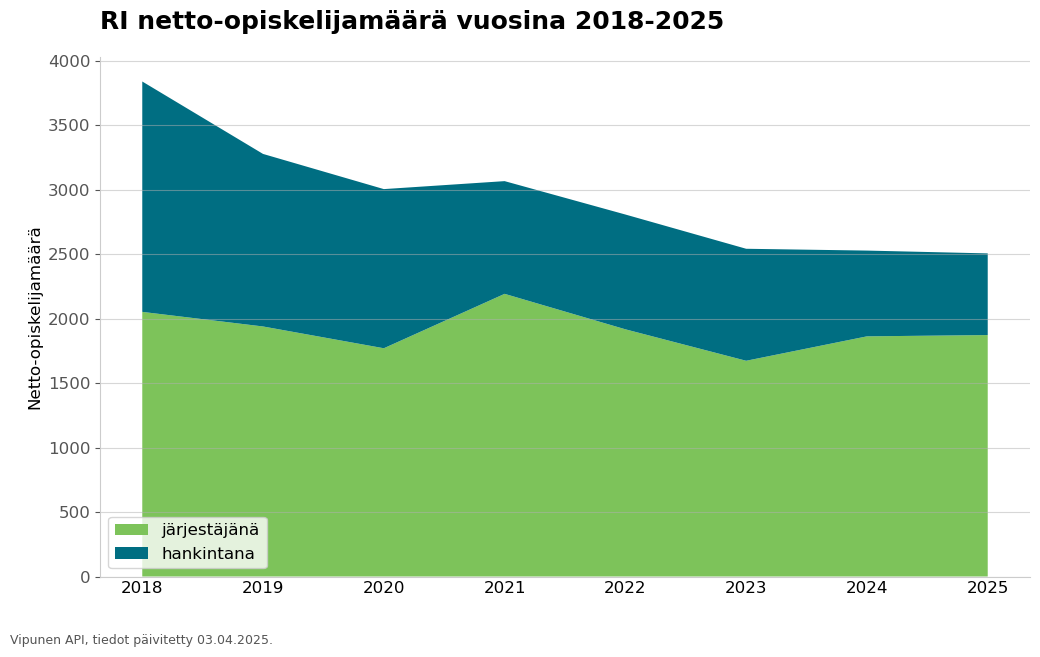

2025-05-05 20:17:11,677 - AnalysisNotebook - INFO - --- Step 3b: Plot 1 Generation Complete ---


In [25]:
# Cell 10: Step 3b - Plot 1: Stacked Area (Total Volumes)
logger.info("--- Step 3b: Generating Plot 1 (Total Volumes Area Chart) ---")

# Check if setup failed or if visualizer is not ready
if '_skip_plots' in globals() and _skip_plots or 'visualizer' not in globals() or visualizer is None:
    logger.warning("Skipping Plot 1 due to setup issues or missing visualizer.")
else:
    fig = None # Ensure fig is defined for finally block
    try:
        total_volumes_df = analysis_results.get('total_volumes')
        required_cols = [year_col, provider_amount_col, subcontractor_amount_col]

        if total_volumes_df is None or total_volumes_df.empty:
            logger.warning("Skipping Total Volumes plot: Data ('total_volumes') not available or empty.")
        elif not all(c in total_volumes_df.columns for c in required_cols):
             missing = [c for c in required_cols if c not in total_volumes_df.columns]
             logger.warning(f"Skipping Total Volumes plot: Missing columns {missing}.")
        else:
            logger.info("Data found. Generating Total Volumes Area Chart...")
            plot_df_roles = total_volumes_df.rename(columns={
                provider_amount_col: 'järjestäjänä',
                subcontractor_amount_col: 'hankintana'
            })
            if 'järjestäjänä' in plot_df_roles.columns and 'hankintana' in plot_df_roles.columns:
                fig, _ = visualizer.create_area_chart(
                    data=plot_df_roles, x_col=year_col, y_cols=['järjestäjänä', 'hankintana'],
                    colors=[COLOR_PALETTES["roles"]["järjestäjänä"], COLOR_PALETTES["roles"]["hankintana"]],
                    labels=['järjestäjänä', 'hankintana'], title=f"{inst_short_name} netto-opiskelijamäärä vuosina {min_year}-{max_year}",
                    caption=base_caption, stacked=True
                )
                visualizer.save_visualization(fig, f"{inst_short_name}_total_volumes_area") # Save to PDF
                logger.info("Plot 1 generated and saved to PDF.")
                display(fig) # <<< ADD THIS LINE TO SHOW INLINE
            else:
                logger.warning("Failed to rename columns for Total Volumes plot.")

    except Exception as e:
        logger.error(f"Failed to generate Plot 1 (Total Volumes): {e}", exc_info=True)
    finally:
         # Ensure figure is closed AFTER displaying
        if fig is not None and plt.fignum_exists(fig.number):
            plt.close(fig)
            logger.debug("Closed Plot 1 figure.")

logger.info("--- Step 3b: Plot 1 Generation Complete ---")


#### Step 3c - Plot 2: Line Charts (Market Share Evolution)


2025-05-05 20:17:11,686 - AnalysisNotebook - INFO - --- Step 3c: Generating Plot 2 (Market Share Line Charts) ---
2025-05-05 20:17:11,687 - AnalysisNotebook - INFO - Generating Market Share Line Charts for 14 active qualifications...


Added figure to PDF: RI_isännöinnin_at_market_share_lines


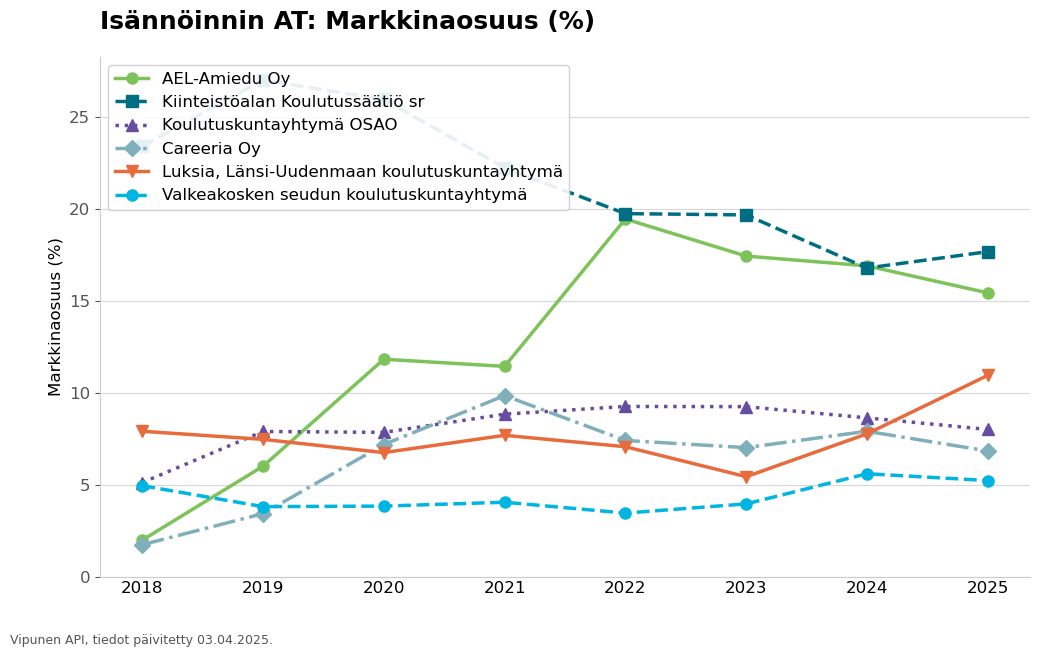

Added figure to PDF: RI_johtamisen_ja_yritysjohtamisen_eat_market_share_lines


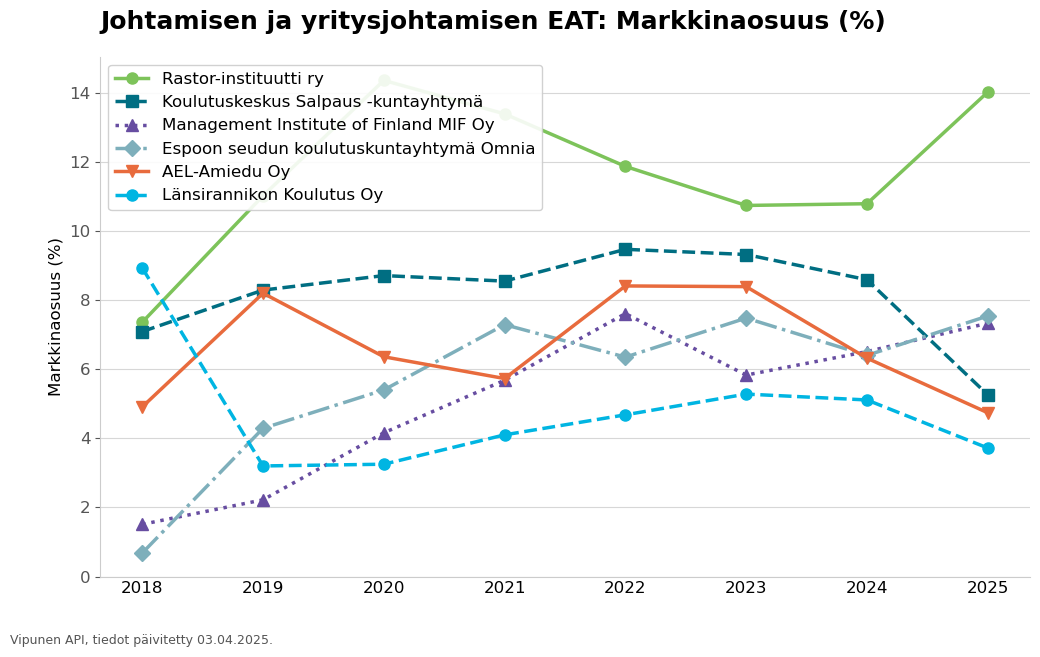

Added figure to PDF: RI_liiketoiminnan_at_market_share_lines


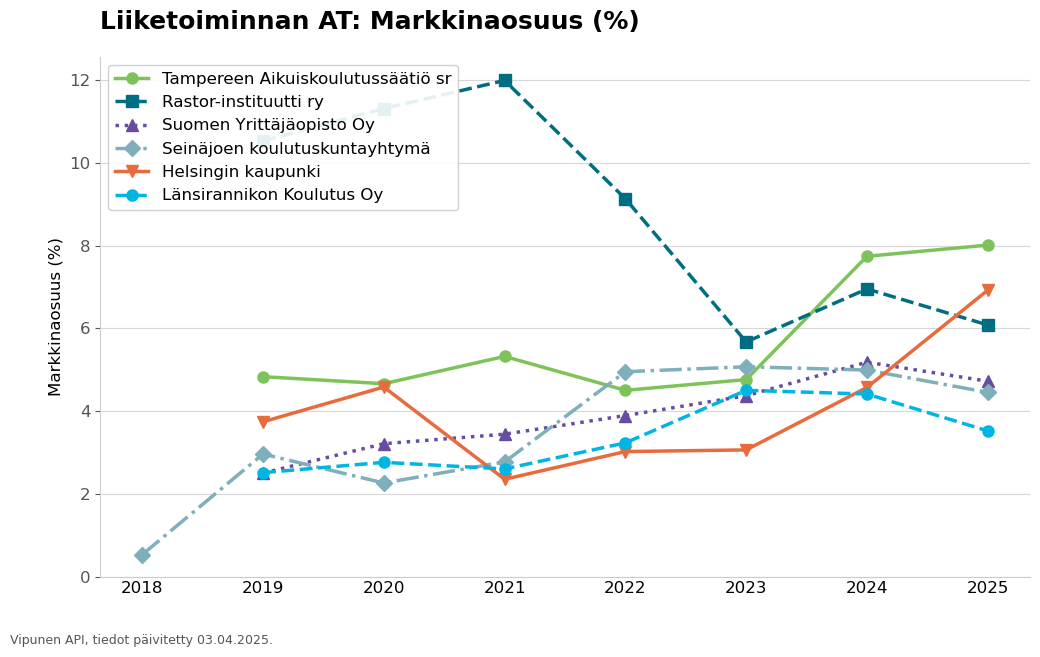

Added figure to PDF: RI_liiketoiminnan_eat_market_share_lines


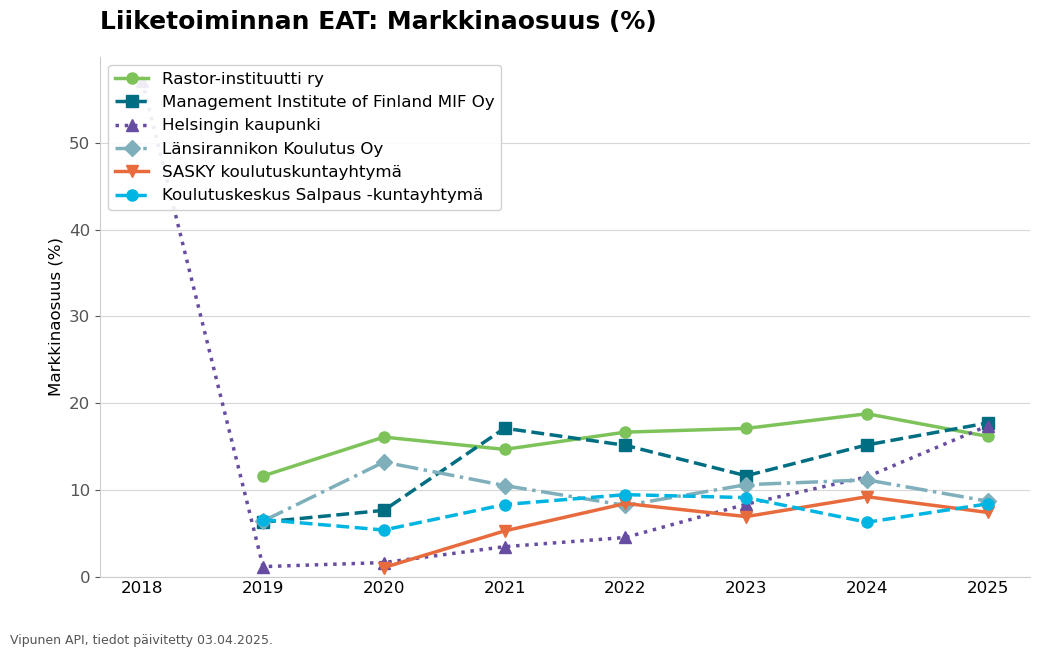

Added figure to PDF: RI_liiketoiminnan_pt_market_share_lines


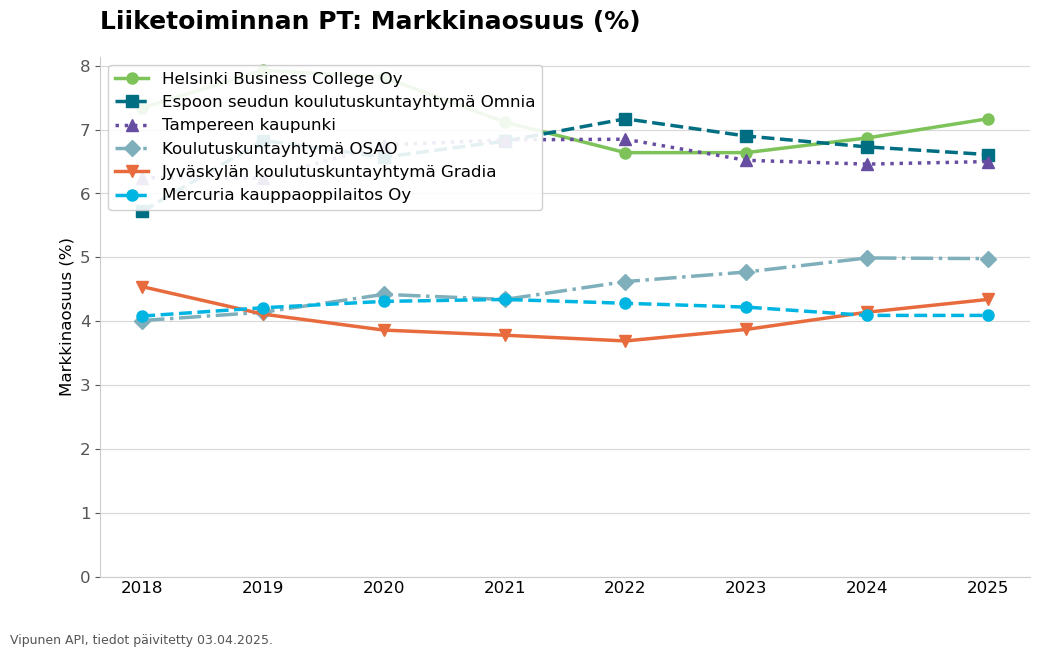

Added figure to PDF: RI_lähiesihenkilötyön_at_market_share_lines


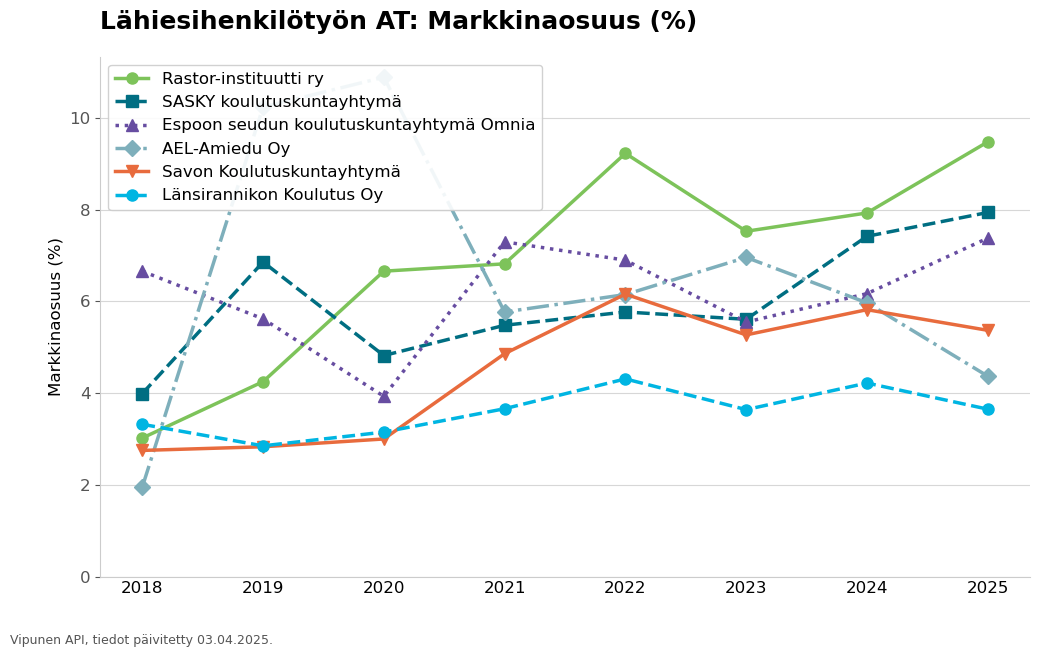

Added figure to PDF: RI_palvelulogistiikan_at_market_share_lines


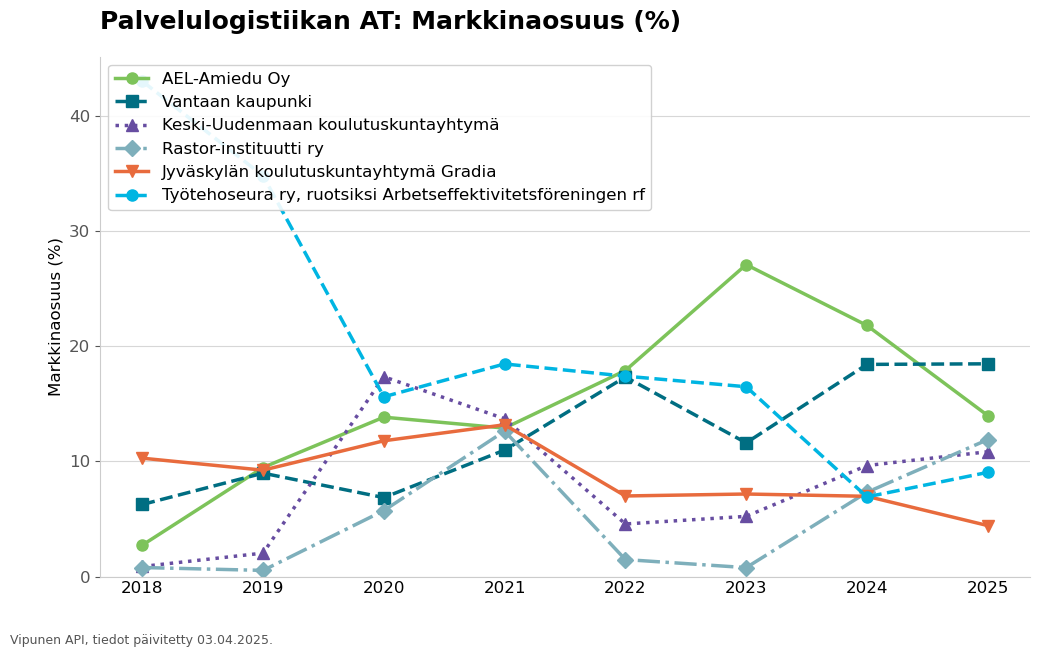

Added figure to PDF: RI_rakennusalan_työmaajohdon_eat_market_share_lines


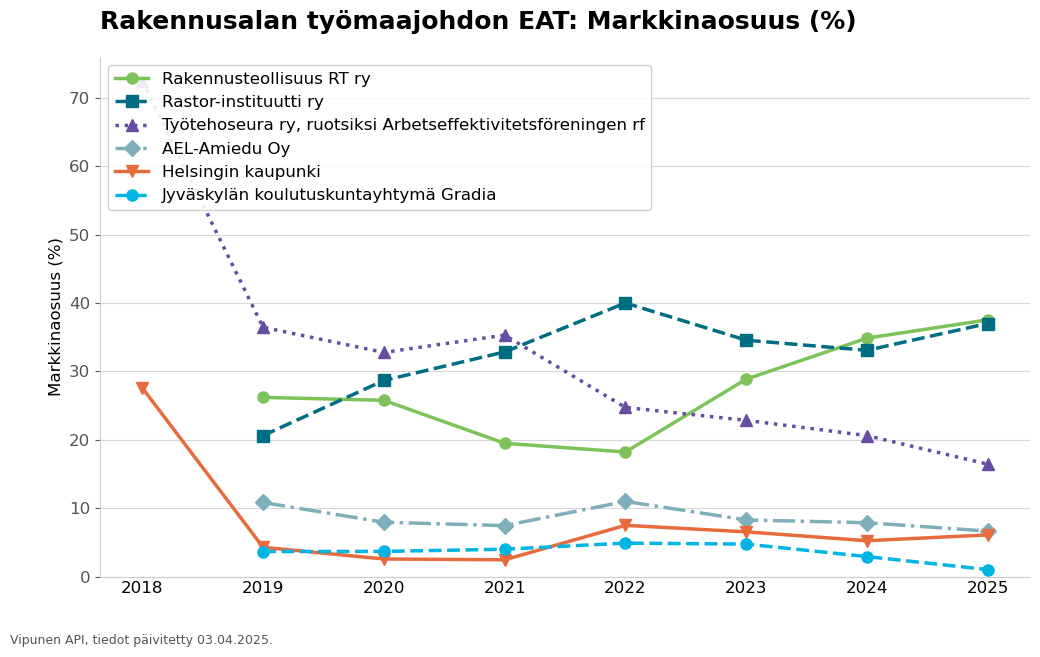

Added figure to PDF: RI_talotekniikan_eat_market_share_lines


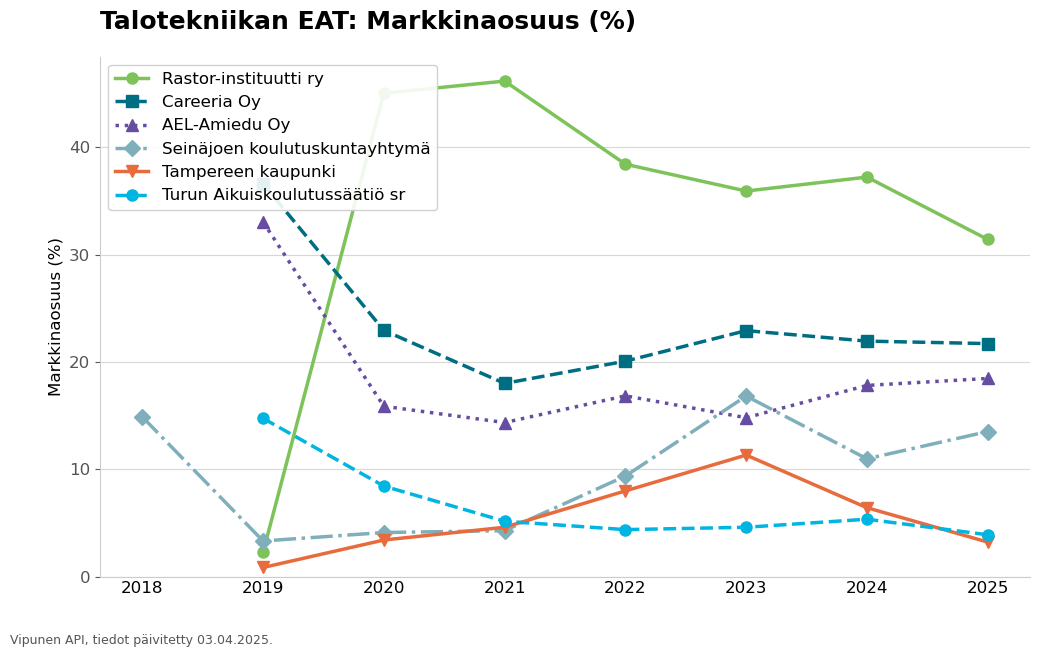

Added figure to PDF: RI_tuotannon_esihenkilötyön_eat_market_share_lines


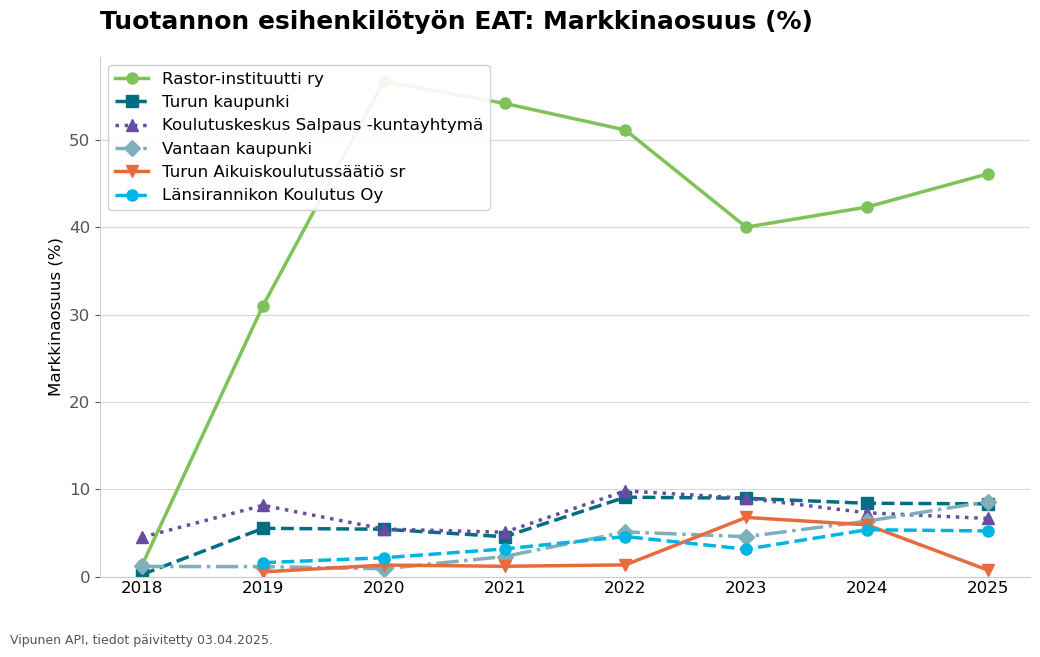

Added figure to PDF: RI_tuotekehitystyön_eat_market_share_lines


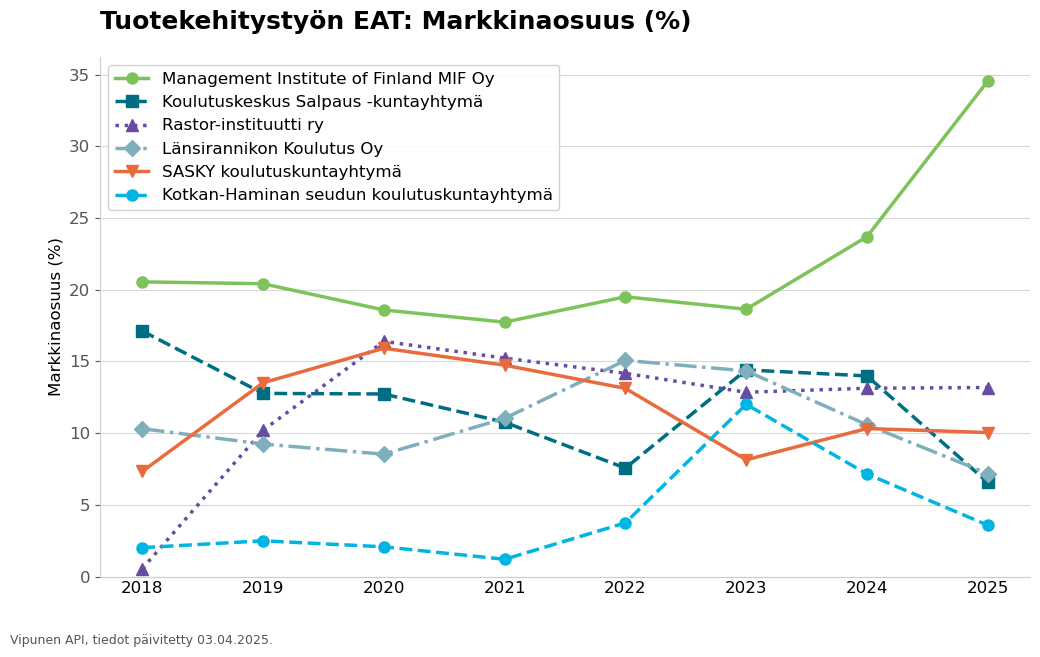

Added figure to PDF: RI_turvallisuusalan_at_market_share_lines


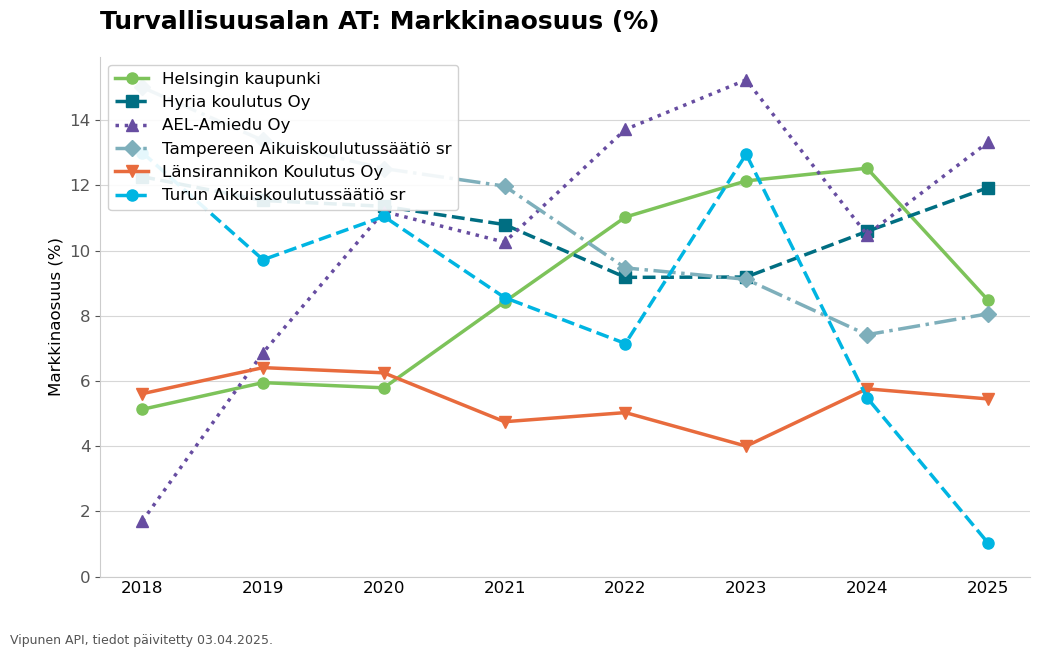

Added figure to PDF: RI_turvallisuusalan_eat_market_share_lines


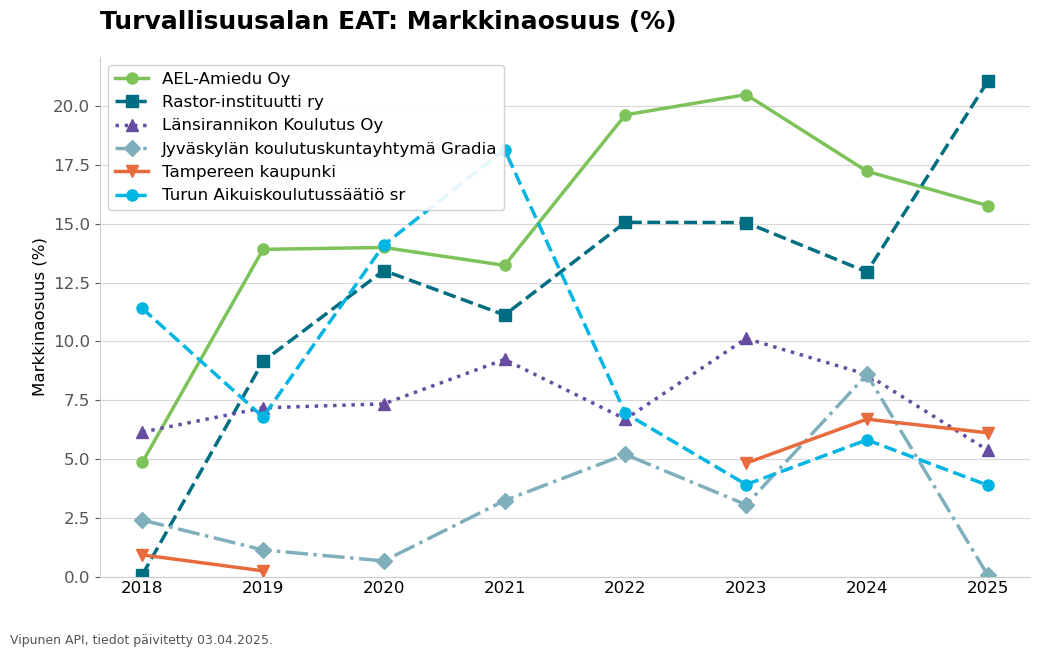

Added figure to PDF: RI_yrittäjyyden_at_market_share_lines


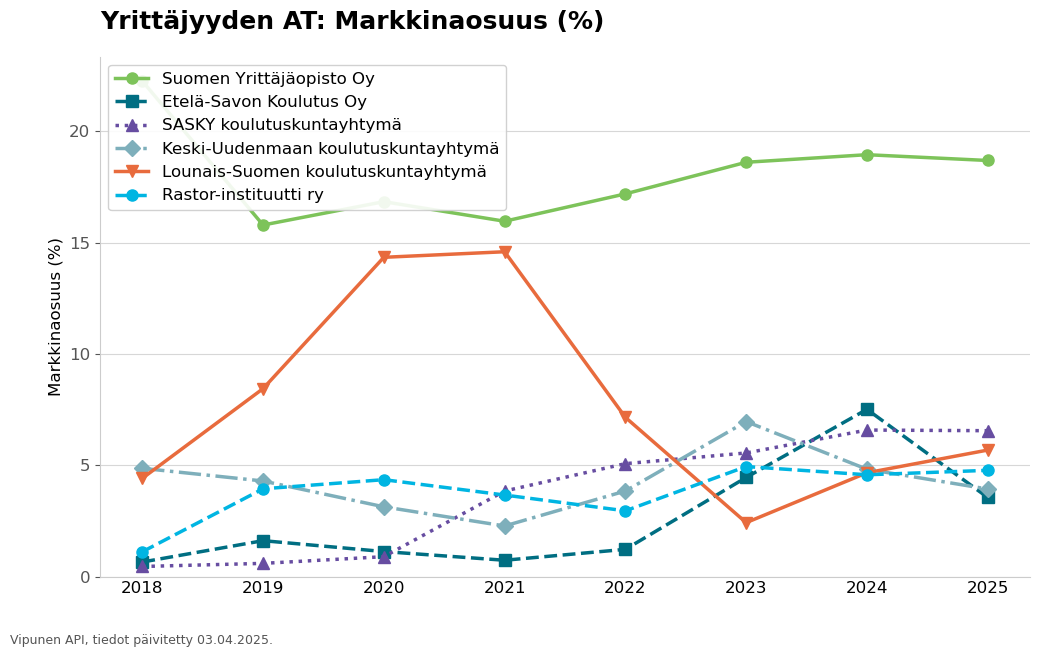

2025-05-05 20:17:13,038 - AnalysisNotebook - INFO - Plot 2 generation attempted. Successfully processed 14/14 charts.
2025-05-05 20:17:13,038 - AnalysisNotebook - INFO - --- Step 3c: Plot 2 Generation Complete ---


In [26]:
# Cell 11: Step 3c - Plot 2: Line Charts (Market Share Evolution)
logger.info("--- Step 3c: Generating Plot 2 (Market Share Line Charts) ---")

# Check if setup failed or if visualizer is not ready
if '_skip_plots' in globals() and _skip_plots or 'visualizer' not in globals() or visualizer is None:
    logger.warning("Skipping Plot 2 due to setup issues or missing visualizer.")
elif 'active_qualifications' not in globals() or not active_qualifications:
     logger.warning("Skipping Plot 2: No active qualifications determined.")
else:
    detailed_df = analysis_results.get('detailed_providers_market')
    required_cols = [qual_col, year_col, provider_col, market_share_col]

    if detailed_df is None or detailed_df.empty:
        logger.warning("Skipping Market Share Line Charts: Data ('detailed_providers_market') missing or empty.")
    elif not all(c in detailed_df.columns for c in required_cols):
        missing = [c for c in required_cols if c not in detailed_df.columns]
        logger.warning(f"Skipping Market Share Line Charts: Missing columns {missing}.")
    else:
        logger.info(f"Generating Market Share Line Charts for {len(active_qualifications)} active qualifications...")
        processed_count = 0
        for qual in active_qualifications:
            fig = None # Define fig inside loop for finally block
            try:
                qual_df = detailed_df[detailed_df[qual_col] == qual]
                if qual_df.empty:
                    logger.debug(f"Skipping line chart for {qual}: No data.")
                    continue

                latest_qual_providers = qual_df[qual_df[year_col] == plot_reference_year]
                # Use nlargest, handling cases where there are fewer than 6 providers
                top_m_providers = latest_qual_providers.nlargest(6, market_share_col)[provider_col].unique().tolist()

                if not top_m_providers:
                     logger.debug(f"Skipping line chart for {qual}: No providers found for top M.")
                     continue

                # Pivot data for plotting
                plot_data = qual_df[qual_df[provider_col].isin(top_m_providers)].pivot(index=year_col, columns=provider_col, values=market_share_col)

                if not plot_data.empty:
                    plot_data.index.name = year_col # Ensure index name for x_col reference
                    # Ensure y_cols exist in the pivoted data
                    valid_y_cols = [col for col in top_m_providers if col in plot_data.columns]
                    
                    if not valid_y_cols:
                        logger.debug(f"Skipping line chart for {qual}: No valid columns after pivot.")
                        continue

                    # Create filename part robustly
                    qual_filename_part = "".join(c if c.isalnum() else "_" for c in qual).lower()[:50]

                    fig, _ = visualizer.create_line_chart(
                        data=plot_data, x_col=plot_data.index, y_cols=valid_y_cols,
                        colors=COLOR_PALETTES["main"], labels=valid_y_cols, # Use valid cols here too
                        title=f"{qual}: Markkinaosuus (%)", caption=base_caption, markers=True
                    )
                    visualizer.save_visualization(fig, f"{inst_short_name}_{qual_filename_part}_market_share_lines") # Save to PDF
                    display(fig) # <<< ADD THIS LINE TO SHOW INLINE
                    processed_count += 1
                else:
                    logger.debug(f"Skipping line chart for {qual}: Pivoted data is empty.")

            except Exception as e:
                logger.error(f"Failed to generate Market Share line plot for '{qual}': {e}", exc_info=True)
            finally:
                # Close figure AFTER potential display
                if fig is not None and plt.fignum_exists(fig.number):
                    plt.close(fig)
                    logger.debug(f"Closed figure for {qual}.")
        logger.info(f"Plot 2 generation attempted. Successfully processed {processed_count}/{len(active_qualifications)} charts.")

logger.info("--- Step 3c: Plot 2 Generation Complete ---")


#### Step 3d - Plot 3: Heatmap (Institution's Market Share)


2025-05-05 20:17:13,050 - AnalysisNotebook - INFO - --- Step 3d: Generating Plot 3 (Market Share Heatmap) ---
2025-05-05 20:17:13,050 - AnalysisNotebook - INFO - Data found. Generating Institution Market Share Heatmap...
2025-05-05 20:17:13,052 - AnalysisNotebook - INFO - Aggregating data for multiple institution variants for heatmap...
2025-05-05 20:17:13,204 - AnalysisNotebook - INFO - Plot 3 generated and saved to PDF.


Added figure to PDF: RI_market_share_heatmap_active


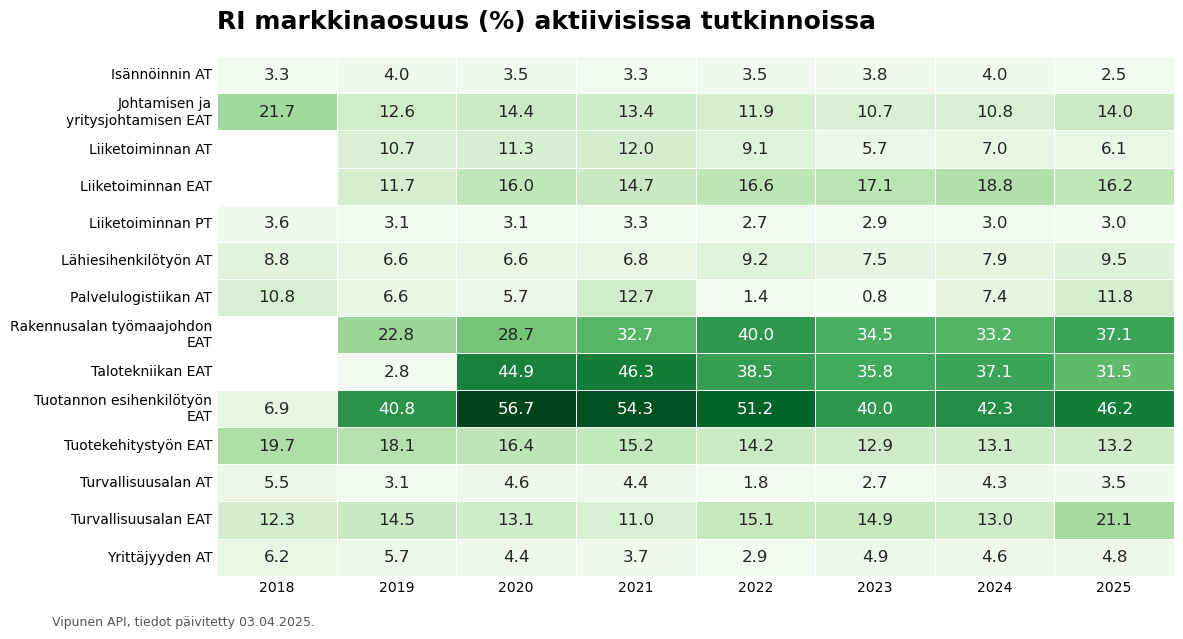

2025-05-05 20:17:13,294 - AnalysisNotebook - INFO - --- Step 3d: Plot 3 Generation Complete ---


In [27]:
logger.info("--- Step 3d: Generating Plot 3 (Market Share Heatmap) ---")

# Check if setup failed or if visualizer is not ready
if '_skip_plots' in globals() and _skip_plots or 'visualizer' not in globals() or visualizer is None:
    logger.warning("Skipping Plot 3 due to setup issues or missing visualizer.")
elif 'active_qualifications' not in globals() or not active_qualifications:
     logger.warning("Skipping Plot 3: No active qualifications determined.")
else:
    fig = None # Define fig for finally block
    try:
        detailed_df = analysis_results.get('detailed_providers_market')
        required_cols = [provider_col, year_col, qual_col, market_share_col] # Basic cols needed

        if detailed_df is None or detailed_df.empty:
            logger.warning("Skipping Heatmap: Data ('detailed_providers_market') missing or empty.")
        elif not all(c in detailed_df.columns for c in required_cols):
             missing = [c for c in required_cols if c not in detailed_df.columns]
             logger.warning(f"Skipping Heatmap: Missing columns {missing}.")
        else:
            logger.info("Data found. Generating Institution Market Share Heatmap...")
            # Filter for institution, handling multiple variants by aggregation if needed
            inst_share_df_raw = detailed_df[detailed_df[provider_col].isin(inst_names)].copy()
            inst_share_df = inst_share_df_raw # Default if only one variant

            if len(inst_names) > 1 and not inst_share_df_raw.empty:
                logger.info("Aggregating data for multiple institution variants for heatmap...")
                # Aggregation logic (copied, assumes columns exist based on earlier checks)
                agg_logic = {
                    provider_amount_col: 'sum', subcontractor_amount_col: 'sum',
                    total_volume_col: 'sum', market_total_col: 'first',
                    market_share_col: 'first', # Placeholder
                }
                # Filter agg_logic based on actual columns present (handle optional cols)
                agg_logic = {k: v for k, v in agg_logic.items() if k in inst_share_df_raw.columns}

                if agg_logic and total_volume_col in agg_logic and market_total_col in agg_logic :
                    inst_share_df_agg = inst_share_df_raw.groupby([year_col, qual_col], as_index=False).agg(agg_logic)
                    # Recalculate market share
                    valid_market_total = inst_share_df_agg[market_total_col] > 0
                    inst_share_df_agg[market_share_col] = 0.0
                    inst_share_df_agg.loc[valid_market_total, market_share_col] = (inst_share_df_agg.loc[valid_market_total, total_volume_col] / inst_share_df_agg.loc[valid_market_total, market_total_col] * 100)
                    inst_share_df = inst_share_df_agg
                else:
                     logger.warning("Aggregation skipped for heatmap: Missing required columns for aggregation (e.g., volume/market totals).")
                     # Decide: use raw (might be misleading) or skip? Let's try using raw.
                     # inst_share_df = inst_share_df_raw # Already set

            # Filter for active qualifications and pivot
            if not inst_share_df.empty:
                inst_share_df_active = inst_share_df[inst_share_df[qual_col].isin(active_qualifications)]
            else:
                 inst_share_df_active = pd.DataFrame() # Ensure empty df if no inst data

            if not inst_share_df_active.empty and market_share_col in inst_share_df_active.columns:
                heatmap_data = inst_share_df_active.pivot_table(index=qual_col, columns=year_col, values=market_share_col)
                heatmap_data = heatmap_data.sort_index() # Sort rows alphabetically by qualification

                if not heatmap_data.empty:
                    fig, _ = visualizer.create_heatmap(
                        data=heatmap_data, title=f"{inst_short_name} markkinaosuus (%) aktiivisissa tutkinnoissa",
                        caption=base_caption, cmap="Greens", annot=True, fmt=".1f"
                    )
                    visualizer.save_visualization(fig, f"{inst_short_name}_market_share_heatmap_active")
                    logger.info("Plot 3 generated and saved to PDF.")
                    display(fig) 
                else:
                     logger.warning(f"Skipping Heatmap: Pivoted data is empty for active qualifications.")
            else:
                 logger.warning(f"Skipping Heatmap: No data for {inst_short_name} in active qualifications or missing market share column.")

    except Exception as e:
        logger.error(f"Failed to generate Plot 3 (Heatmap): {e}", exc_info=True)
    finally:
        if fig is not None and plt.fignum_exists(fig.number):
            plt.close(fig)
            logger.debug("Closed Plot 3 figure.")

logger.info("--- Step 3d: Plot 3 Generation Complete ---")


#### Step 3e - Plot 4: BCG Growth-Share Matrix


2025-05-05 20:17:13,300 - AnalysisNotebook - INFO - --- Step 3e: Generating Plot 4 (BCG Matrix) ---
2025-05-05 20:17:13,301 - AnalysisNotebook - INFO - Data found. Generating BCG Growth-Share Matrix...
2025-05-05 20:17:13,308 - src.vipunen.visualization.education_visualizer - INFO - Using calculated average market growth for BCG divider: -7.43%
2025-05-05 20:17:13,426 - AnalysisNotebook - INFO - Plot 4 generated and saved to PDF.


Added figure to PDF: RI_bcg_matrix


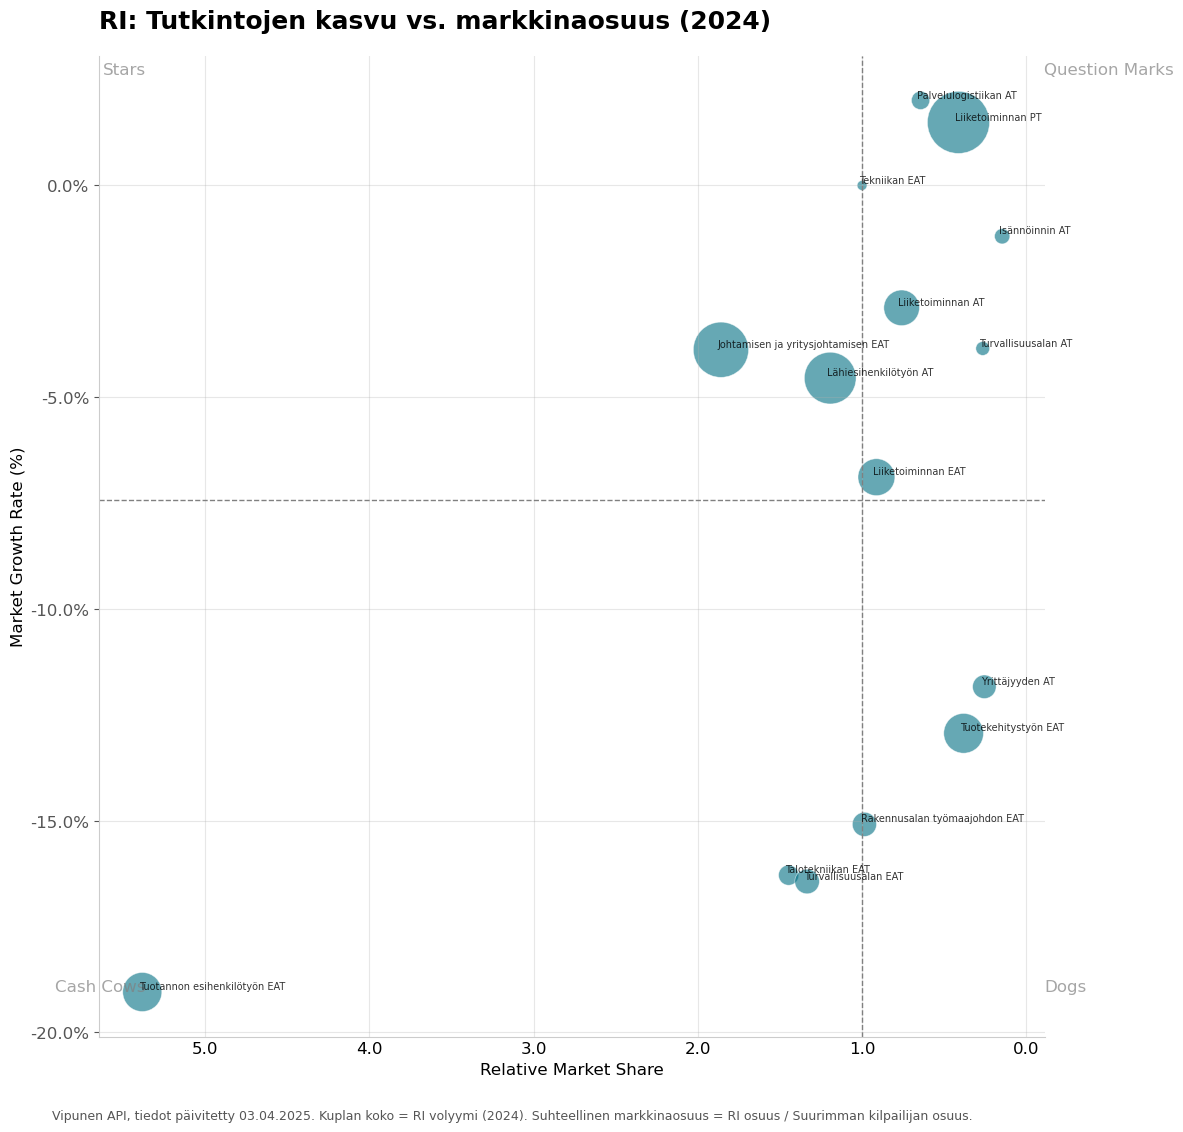

2025-05-05 20:17:13,500 - AnalysisNotebook - INFO - --- Step 3e: Plot 4 Generation Complete ---


In [28]:
logger.info("--- Step 3e: Generating Plot 4 (BCG Matrix) ---")

# Check if setup failed or if visualizer is not ready
if _skip_plots or visualizer is None:
    logger.warning("Skipping Plot 4 due to setup issues or missing visualizer.")
else:
    fig = None # Define fig for finally block
    try:
        bcg_data_df = analysis_results.get('bcg_data')
        # Columns defined in setup cell: qual_col, bcg_growth_col, bcg_share_col, bcg_size_col
        required_cols = [bcg_growth_col, bcg_share_col, bcg_size_col] # Label col checked separately

        if bcg_data_df is None or bcg_data_df.empty:
             logger.warning("Skipping BCG Matrix: Data ('bcg_data') not available or empty.")
        elif not all(c in bcg_data_df.columns for c in required_cols):
             missing = [c for c in required_cols if c not in bcg_data_df.columns]
             logger.warning(f"Skipping BCG Matrix: Missing required data columns {missing}. Found: {bcg_data_df.columns.tolist()}")
        else:
            # Find the actual qualification column name used in the bcg_data df
            actual_qual_col = None
            if qual_col in bcg_data_df.columns: # Check if config output name is used
                 actual_qual_col = qual_col
            elif 'Qualification' in bcg_data_df.columns: # Check for hardcoded alternative
                 actual_qual_col = 'Qualification'
            # Add more checks if other names are possible

            if actual_qual_col is None:
                 logger.warning(f"Skipping BCG Matrix: Could not find qualification/label column (checked '{qual_col}', 'Qualification'). Found: {bcg_data_df.columns.tolist()}")
            else:
                logger.info("Data found. Generating BCG Growth-Share Matrix...")
                plot_title = f"{inst_short_name}: Tutkintojen kasvu vs. markkinaosuus ({plot_reference_year})"
                bcg_caption = base_caption + f" Kuplan koko = {inst_short_name} volyymi ({plot_reference_year}). Suhteellinen markkinaosuus = {inst_short_name} osuus / Suurimman kilpailijan osuus."

                fig, _ = visualizer.create_bcg_matrix(
                    data=bcg_data_df, growth_col=bcg_growth_col, share_col=bcg_share_col,
                    size_col=bcg_size_col, label_col=actual_qual_col, # Use the found column
                    title=plot_title, caption=bcg_caption
                )
                visualizer.save_visualization(fig, f"{inst_short_name}_bcg_matrix")
                logger.info("Plot 4 generated and saved to PDF.")
                display(fig)

    except Exception as e:
        logger.error(f"Failed to generate Plot 4 (BCG Matrix): {e}", exc_info=True)
    finally:
        if fig is not None and plt.fignum_exists(fig.number):
            plt.close(fig)
            logger.debug("Closed Plot 4 figure.")

logger.info("--- Step 3e: Plot 4 Generation Complete ---")




#### Step 3f - Plot 5: Combined Volume / Provider Count


2025-05-05 20:17:13,507 - AnalysisNotebook - INFO - --- Step 3f: Generating Plot 5 (Volume / Provider Count) ---
2025-05-05 20:17:13,508 - AnalysisNotebook - INFO - Data found. Generating Volume / Provider Count Plot...
2025-05-05 20:17:13,622 - AnalysisNotebook - INFO - Plot 5 generated and saved to PDF.


Added figure to PDF: RI_volume_provider_counts


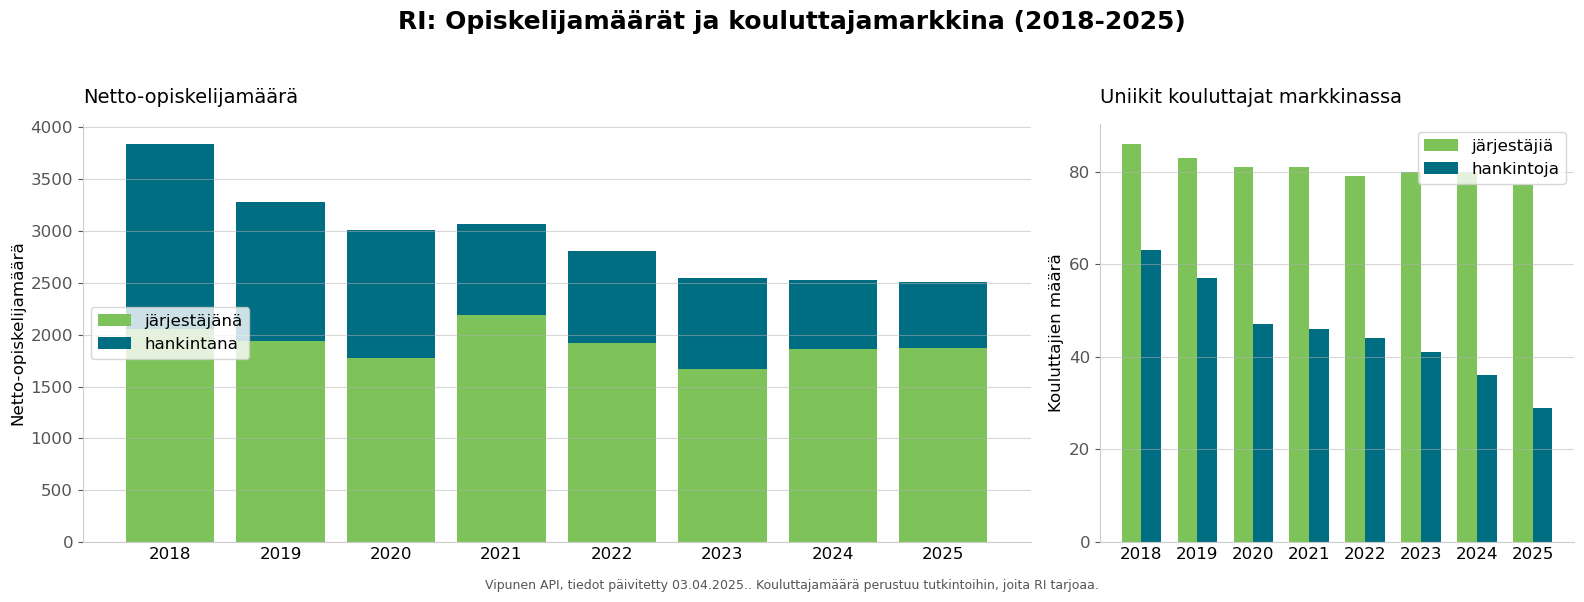

2025-05-05 20:17:13,704 - AnalysisNotebook - INFO - --- Step 3f: Plot 5 Generation Complete ---


In [29]:
logger.info("--- Step 3f: Generating Plot 5 (Volume / Provider Count) ---")

# Check if setup failed or if visualizer is not ready
if _skip_plots or visualizer is None:
    logger.warning("Skipping Plot 5 due to setup issues or missing visualizer.")
else:
    fig = None # Define fig for finally block
    try:
        volume_df = analysis_results.get('total_volumes')
        count_df = analysis_results.get('provider_counts_by_year')
        # Required columns defined in setup cell
        req_vol_cols = [year_col, provider_amount_col, subcontractor_amount_col]
        req_count_cols = [year_col, count_provider_col, count_subcontractor_col]

        if volume_df is None or volume_df.empty:
             logger.warning("Skipping Volume/Provider Count plot: Volume data ('total_volumes') missing or empty.")
        elif count_df is None or count_df.empty:
             logger.warning("Skipping Volume/Provider Count plot: Count data ('provider_counts_by_year') missing or empty.")
        elif not all(c in volume_df.columns for c in req_vol_cols):
             missing = [c for c in req_vol_cols if c not in volume_df.columns]
             logger.warning(f"Skipping Volume/Provider Count plot: Missing volume columns {missing}.")
        elif not all(c in count_df.columns for c in req_count_cols):
             missing = [c for c in req_count_cols if c not in count_df.columns]
             logger.warning(f"Skipping Volume/Provider Count plot: Missing count columns {missing}.")
        else:
            logger.info("Data found. Generating Volume / Provider Count Plot...")
            plot_title = f"{inst_short_name}: Opiskelijamäärät ja kouluttajamarkkina ({min_year}-{max_year})"
            plot_caption = base_caption + f". Kouluttajamäärä perustuu tutkintoihin, joita {inst_short_name} tarjoaa."

            fig, _ = visualizer.create_volume_and_provider_count_plot(
                volume_data=volume_df, count_data=count_df, title=plot_title,
                volume_title="Netto-opiskelijamäärä", count_title="Uniikit kouluttajat markkinassa",
                year_col=year_col, vol_provider_col=provider_amount_col, vol_subcontractor_col=subcontractor_amount_col,
                count_provider_col=count_provider_col, count_subcontractor_col=count_subcontractor_col,
                caption=plot_caption
            )
            visualizer.save_visualization(fig, f"{inst_short_name}_volume_provider_counts")
            logger.info("Plot 5 generated and saved to PDF.")
            display(fig)

    except Exception as e:
        logger.error(f"Failed to generate Plot 5 (Volume/Provider Count): {e}", exc_info=True)
    finally:
        if fig is not None and plt.fignum_exists(fig.number):
            plt.close(fig)
            logger.debug("Closed Plot 5 figure.")

logger.info("--- Step 3f: Plot 5 Generation Complete ---")


#### Step 3g - Finalize PDF Report


In [30]:
logger.info("--- Step 3g: Finalizing PDF Report ---")

# Check if setup failed or if visualizer is not ready
if _skip_plots or visualizer is None:
    logger.warning("Skipping PDF finalization due to setup issues or missing visualizer.")
    pdf_report_path = None # Ensure path is None
else:
    try:
        logger.info(f"Closing PDF file: {visualizer.pdf_path}...")
        # The close_pdf method implicitly saves the collected pages
        visualizer.close_pdf()
        pdf_report_path = visualizer.pdf_path # Get the final path
        if pdf_report_path and pdf_report_path.exists():
             logger.info(f"PDF report successfully saved to: {pdf_report_path}")
        elif pdf_report_path:
             logger.warning(f"Visualizer reported PDF path {pdf_report_path}, but file does not exist.")
             pdf_report_path = None # Set path to None if file doesn't exist
        else:
             logger.warning("Could not determine PDF report path from visualizer after closing.")
             pdf_report_path = None

    except Exception as e:
        logger.error(f"An error occurred during PDF finalization: {e}", exc_info=True)
        pdf_report_path = None # Ensure path is None on error
        # Attempt to close if handle seems open (defensive)
        if hasattr(visualizer, 'pdf_pages') and visualizer.pdf_pages is not None:
             try: visualizer.close_pdf()
             except: pass # Ignore errors during secondary close attempt

# Print final path for user
print(f"\nPDF Report Path: {pdf_report_path if pdf_report_path else 'Not generated or failed'}")
logger.info("--- Step 3g: PDF Finalization Complete ---")


2025-05-05 20:17:13,710 - AnalysisNotebook - INFO - --- Step 3g: Finalizing PDF Report ---
2025-05-05 20:17:13,710 - AnalysisNotebook - INFO - Closing PDF file: /Users/topi/data-science/repos/vipunen-market-analysis/data/reports/education_market_ri/ri_visualizations_20250505_201711.pdf...
2025-05-05 20:17:13,734 - AnalysisNotebook - INFO - PDF report successfully saved to: /Users/topi/data-science/repos/vipunen-market-analysis/data/reports/education_market_ri/ri_visualizations_20250505_201711.pdf
2025-05-05 20:17:13,734 - AnalysisNotebook - INFO - --- Step 3g: PDF Finalization Complete ---


Closing PDF file with content at /Users/topi/data-science/repos/vipunen-market-analysis/data/reports/education_market_ri/ri_visualizations_20250505_201711.pdf...
PDF file successfully closed.

PDF Report Path: /Users/topi/data-science/repos/vipunen-market-analysis/data/reports/education_market_ri/ri_visualizations_20250505_201711.pdf


## Step 4: Export Final Results (Excel)

In [31]:
logger.info("--- Step 4: Exporting Final Results to Excel ---")

excel_path = None # Initialize path
try:
    # Ensure analysis results are available
    if 'analysis_results' not in locals() or not analysis_results:
        logger.warning("Analysis results missing. Skipping Excel Export.")
    else:
        # --- Create Metadata ---
        logger.info("Creating metadata for export...")
        metadata = {
            "Analysis Timestamp": datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            "Institution Analyzed": f"{institution_name} ({institution_short_name})", # Use variables from Step 1
            "Institution Variants Used": ", ".join(institution_names_to_match),
            "Input Data File": str(data_file),
            "Data Update Date": data_update_date_str,
            "Qualification Type Filter Applied": "Yes" if filter_qual_types_flag else "No",
            "Min Market Size Threshold (for plots)": config.get('analysis', {}).get('min_market_size_threshold', 'N/A'),
            "Active Qualifications Filter Threshold (for plots)": config.get('analysis', {}).get('active_qualification_min_volume_sum', 'N/A')
        }
        metadata_df = pd.DataFrame(metadata.items(), columns=["Parameter", "Value"])
        logger.info("Metadata created successfully.")
        print("\n--- Analysis Metadata ---")
        print(metadata_df)
        
        # --- Use Correct Base Output Path from Setup ---
        # Ensure output_base_dir from setup cell is available and is a Path
        if 'output_base_dir' not in globals() or not isinstance(output_base_dir, Path):
            logger.error("Base output directory (output_base_dir) not found or not a Path object. Cannot determine Excel path.")
            raise NameError("output_base_dir is not defined or is not a Path")
        
        logger.info(f"Using base output directory for Excel export: {output_base_dir.resolve()}")

        # --- Call Exporter ---
        # Use the wrapper function from analyze_cli which handles filename and dict prep
        # Pass the CORRECT output_base_dir (as string) from the setup cell
        excel_path = export_analysis_results(
            analysis_results=analysis_results,
            config=config,
            institution_short_name=institution_short_name,
            base_output_path=str(output_base_dir), # Pass the correct absolute path
            metadata_df=metadata_df,
            include_timestamp=ANALYSIS_PARAMS.get('include_timestamp', True)
        )
        
        if excel_path:
            logger.info(f"Successfully exported results to Excel: {excel_path}")
        else:
            logger.warning("Excel export function did not return a valid path.")
            
        logger.info("--- Step 4: Excel Export Complete ---")

except Exception as e:
    logger.error(f"An unexpected error occurred during Excel export: {e}", exc_info=True)
    # excel_path remains None or its previous value

2025-05-05 20:17:13,741 - AnalysisNotebook - INFO - --- Step 4: Exporting Final Results to Excel ---
2025-05-05 20:17:13,742 - AnalysisNotebook - INFO - Creating metadata for export...
2025-05-05 20:17:13,743 - AnalysisNotebook - INFO - Metadata created successfully.
2025-05-05 20:17:13,744 - AnalysisNotebook - INFO - Using base output directory for Excel export: /Users/topi/data-science/repos/vipunen-market-analysis/data/reports
2025-05-05 20:17:13,744 - src.vipunen.cli.analyze_cli - INFO - Exporting analysis results to Excel...
2025-05-05 20:17:13,745 - src.vipunen.cli.analyze_cli - WARNING - Could not reliably determine relative path ('/Users/topi/data-science/repos/vipunen-market-analysis/data/reports/education_market_ri' is not in the subpath of 'data' OR one path is relative and the other is absolute.). Using full path: /Users/topi/data-science/repos/vipunen-market-analysis/data/reports/education_market_ri
2025-05-05 20:17:13,745 - src.vipunen.cli.analyze_cli - INFO - Calculated 


--- Analysis Metadata ---
                                           Parameter  \
0                                 Analysis Timestamp   
1                               Institution Analyzed   
2                          Institution Variants Used   
3                                    Input Data File   
4                                   Data Update Date   
5                  Qualification Type Filter Applied   
6              Min Market Size Threshold (for plots)   
7  Active Qualifications Filter Threshold (for pl...   

                                             Value  
0                              2025-05-05 20:17:13  
1                       Rastor-instituutti ry (RI)  
2                 Rastor-instituutti ry, Rastor Oy  
3  amm_opiskelijat_ja_tutkinnot_vuosi_tutkinto.csv  
4                                       03.04.2025  
5                                               No  
6                                                5  
7                                           

/Users/topi/miniconda3/envs/vipunen-analytics/lib/python3.9/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


2025-05-05 20:17:14,451 - FileUtils.core.file_utils - INFO - Data saved successfully: {'Sheet1': '/Users/topi/data-science/repos/vipunen-market-analysis/data/reports/education_market_ri/ri_market_analysis_20250505_201713.xlsx'}


2025-05-05 20:17:14,451 - FileUtils.core.file_utils - INFO - Data saved successfully: {'Sheet1': '/Users/topi/data-science/repos/vipunen-market-analysis/data/reports/education_market_ri/ri_market_analysis_20250505_201713.xlsx'}
2025-05-05 20:17:14,451 - src.vipunen.export.excel_exporter - INFO - Exported Excel file to /Users/topi/data-science/repos/vipunen-market-analysis/data/reports/education_market_ri/ri_market_analysis_20250505_201713.xlsx
2025-05-05 20:17:14,452 - src.vipunen.cli.analyze_cli - INFO - Excel export successful: /Users/topi/data-science/repos/vipunen-market-analysis/data/reports/education_market_ri/ri_market_analysis_20250505_201713.xlsx
2025-05-05 20:17:14,452 - AnalysisNotebook - INFO - Successfully exported results to Excel: /Users/topi/data-science/repos/vipunen-market-analysis/data/reports/education_market_ri/ri_market_analysis_20250505_201713.xlsx
2025-05-05 20:17:14,452 - AnalysisNotebook - INFO - --- Step 4: Excel Export Complete ---


## Step 5: Custom User Analysis Area

In [32]:
logger.info("--- Step 5: Custom Analysis Area ---")

2025-05-05 20:17:14,455 - AnalysisNotebook - INFO - --- Step 5: Custom Analysis Area ---


The main analysis workflow is complete.
Key variables available for further analysis:
- config: The loaded project configuration dictionary.
- ANALYSIS_PARAMS: The parameters used for this specific run.
- df_raw: The raw data loaded initially.
- df_prepared: The cleaned and filtered data used for the main analysis.
- analysis_results: A dictionary containing the various analysis DataFrames.
    Keys: ['total_volumes', 'volumes_by_qualification', 'detailed_providers_market', 
           'qualification_cagr', 'overall_total_market_volume', 
           'qualification_market_yoy_growth', 'provider_counts_by_year', 'bcg_data']
- analyzer: The MarketAnalyzer instance.
- pdf_report_path: Path to the generated PDF report (if successful).
- excel_path: The path to the generated Excel file (if export was successful).
- institution_short_name: Short name of the analyzed institution.
- institution_variants: List of variants used for matching.
- data_update_date_str: The data update date string.

### Additional Analyses

TODO: Add Section for Custom User Analysis

In [33]:

# if __name__ == "__main__":
#     # This block allows running the script directly, mimicking notebook execution
#     logger.info("Running analysis script...")
    
#     # Placeholder for calling the main workflow steps
#     if 'df_prepared' in locals():
#         logger.info("Data preparation step appears complete.")
#         if 'analysis_results' in locals() and analysis_results:
#             logger.info("Market analysis step appears complete.")
#             # Check for PDF path instead of figures dict
#             if 'pdf_report_path' in locals() and pdf_report_path:
#                 logger.info("PDF Visualization step appears complete.")
#             else:
#                 logger.warning("PDF Visualization step may have failed or was skipped.")
#         elif 'analysis_results' in locals():
#              logger.warning("Market analysis step completed but produced no results.")
#         else:
#             logger.warning("Market analysis step may have failed, 'analysis_results' not found.")
            
#         if 'excel_path' in locals() and excel_path:
#              logger.info("Excel export step appears complete.")
#         else:
#              logger.warning("Excel export step may have failed or was skipped.")
            
#     else:
#         logger.warning("Data preparation step may have failed, 'df_prepared' not found.")

#     # Example: Accessing a config value
#     try:
#         data_path_from_config = config.get('paths', {}).get('data', 'Not Found')
#         logger.info(f"Data path from config: {data_path_from_config}")
#     except Exception as e:
#         logger.error(f"Error accessing config: {e}")
        
#     logger.info("Analysis script finished.") 